# CAICT 風機結冰預測 - Data Exploration 

 ### 2017/08/04
http://www.industrial-bigdata.com/competition/competitionAction!showDetail.action?competition.competitionId=1

In [299]:
from IPython.display import HTML
HTML('''<script>
presentation = 0;
code_show=true; 
function code_toggle() {
 if (!presentation){
     return;
 }
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')


<a id='home'></a>
### Outline
[1. Modules](#load)  
[2. Input Data](#input)  
[3. Single Variable Exploration](#single)    
[4. Multi-Variable Exploration](#multi)
[5. dimension reduction](#dimen)

In [300]:
%matplotlib inline
import sys
import os
import datetime
import pandas as pd
from PIL import Image
import numpy as np
import lzma
import pickle
from IPython.display import display
import shutil
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pylab import *
from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import display, HTML
from sklearn.decomposition import PCA
from sklearn import preprocessing
from mpl_toolkits import mplot3d
import scipy.stats as stats
import pylab
import plastid
from IPython.display import HTML
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression,Lasso,Ridge
import xgboost as xgb
import warnings
from collections import OrderedDict

import sklearn as sk
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all"

In [301]:
def StandardScaler(data):
    standard_scaler = preprocessing.StandardScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled

def MinMaxScaler(data):
    standard_scaler = preprocessing.MinMaxScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled


def load_resample_data(mid, policy=1,  ycol='power'):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=mid,POLICY=policy)
    print('load file:',filename)
    data_resample = pd.read_csv(filename)
    data_resample['label']=data_resample['label'].fillna(2)

    data_X = data_resample.drop(['label','time','group','timestamp','event'], axis=1)
    data_y = data_resample[ycol]
    data_Y = np.eye(data_y.unique().size)[data_y.values.astype(int)]
    return data_resample, data_X, data_Y, data_y


def load_resample_data_passonly(mid, policy=1, ycol='label'):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=mid,POLICY=policy)
    data_resample = pd.read_csv(filename)
    data_resample = data_resample[data_resample['label']==0]
    data_resample=data_resample.dropna()
    data_X = data_resample.drop(['label','time','group','timestamp','event'], axis=1)
    data_X = data_X.drop([ycol], axis=1)
    data_y = data_resample[ycol]
    data_Y = np.eye(data_y.unique().size)[data_y.values.astype(int)]
    return data_resample, data_X, data_Y, data_y


def load_resample_data_split(mid, split_case, policy=1, ycol='power'):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=mid,POLICY=policy)
    data_resample = pd.read_csv(filename)
    data_resample['label']=data_resample['label'].fillna(2)
    #data_resample = data_resample[data_resample['label']!=2]
    #data_resample=data_resample.dropna()
    data_resample_train = data_resample[data_resample['event']<split_case]
    data_resample_valid = data_resample[data_resample['event']>=split_case]
    train_X = data_resample_train.drop(['label','time','group','timestamp','event'], axis=1)
    train_X = train_X.drop([ycol], axis=1)
    train_y = data_resample_train[ycol]
    valid_X = data_resample_valid.drop(['label','time','group','timestamp','event'], axis=1)
    valid_X = valid_X.drop([ycol], axis=1)
    valid_y = data_resample_valid[ycol]
    train_Y = np.eye(train_y.unique().size)[train_y.values.astype(int)]
    valid_Y = np.eye(valid_y.unique().size)[valid_y.values.astype(int)]
    return data_resample, train_X, train_Y, train_y, valid_X, valid_Y, valid_y

def load_test2_data():
    test_data = pd.read_csv('data/ice1/test/08/08_data.csv')
    test_timeidx = test_data['time']
    tmp = test_data.drop(['time','group'], axis=1)
    test_X = tmp
    return test_data, test_X, test_timeidx

def load_traindata_puwercurve_analysis(mid=15,policy=0):
    non_data_cols = ['label','time','group','timestamp','event']
    data_raw, data_X, _, _ = load_resample_data(mid=mid,policy=policy)
    data_scaled = MinMaxScaler(data_X)
    for col in non_data_cols:
        data_scaled[col] = data_raw[col]
    return data_raw,data_scaled

def load_testdata_puwercurve_analysis():
    non_data_cols = ['time','group']
    data_raw, data_X, _ = load_test2_data()
    data_scaled = MinMaxScaler(data_X)
    for col in non_data_cols:
        data_scaled[col] = data_raw[col]
    return data_raw,data_scaled

In [302]:
color_ewma={'power':'blue', 'wind_speed':'darkorange'}
color_rollstd={'power':'darkorchid', 'wind_speed':'darkorchid'}
color_predewma={'power':'chartreuse'}
color_predmadiffsum={'power':'black'}

def trend_chart_combine(data, event_id, varlist=['label'], ma=50):
    if type(event_id) is int:
        event_id=[event_id]
    #print('event:',event_id)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        #evtdata_abnor=evtdata[evtdata['label']==1]
        fail_timestamp = evtdata[evtdata['label']==1].index.tolist()[0]
        try:
            unknown_timestamp = evtdata[evtdata['label']==2].index.tolist()[0]
        except:
            unknown_timestamp=None
            
        dummy = plt.figure(figsize=[17,2])
        for var in varlist:
            dummy = plt.plot(pd.ewma(evtdata[var], halflife=ma),lw=1.2, color=color_ewma.get(var), label= var+'(ewma)')
        plt.axvline(fail_timestamp, color='r', linestyle='dashed', lw=0.5)
        if unknown_timestamp:
            plt.axvline(unknown_timestamp, color='b', linestyle='dashed', lw=0.5)
        plt.legend(loc='upper left')
        plt.title('event '+str(eid)+'\t'+str(varlist))
        plt.show()
    

def trend_chart_pred(data, event_id, varlist=['label'], ma=50):
    if type(event_id) is int:
        event_id=[event_id]
    #print('event:',event_id)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        #evtdata_abnor=evtdata[evtdata['label']==1]
        fail_timestamp = evtdata[evtdata['label']==1].index.tolist()[0]
        try:
            unknown_timestamp = evtdata[evtdata['label']==2].index.tolist()[0]
        except:
            unknown_timestamp=None
        dummy = plt.figure(figsize=[17,2])
        for var in varlist:
            dummy = plt.plot(pd.ewma(evtdata[var], halflife=ma),lw=1.2, label= var+'(ewma)',color=color_ewma.get(var))
        
        dummy = plt.plot(pd.ewma(evtdata['pred'], halflife=ma),lw=1.2, label= 'power pred(ewma)', color=color_predewma.get('power') )
        dummy = plt.plot(pd.ewmstd(evtdata['power'],halflife=ma) ,lw=0.8, label='power ewmstd',  color=color_rollstd.get('power'))
        
        #dummy = plt.plot(evtdata['timestamp'],pd.rolling_sum(evtdata['perd_diff'],ma) ,lw=0.8, label='power pred diffsum')
        dummy = plt.plot(evtdata['perd_madiff'] ,lw=0.8, label='power pred madiffsum', color=color_predmadiffsum.get('power'))
        
        plt.axvline(fail_timestamp, color='r', linestyle='dashed', lw=0.5)
        if unknown_timestamp:
            plt.axvline(unknown_timestamp, color='b', linestyle='dashed', lw=0.5)
        plt.legend(loc='upper left')
        plt.title('event '+str(eid)+'\t'+str(varlist)+'\t'+'- Predition')
        plt.show()
        
def trend_chard_predlabel(data, event_id):
    if type(event_id) is int:
        event_id=[event_id]
    #print('event:',event_id)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        fail_timestamp = evtdata[evtdata['label']==1].index.tolist()[0]
        try:
            unknown_timestamp = evtdata[evtdata['label']==2].index.tolist()[0]
        except:
            unknown_timestamp=None
        dummy = plt.figure(figsize=[17,2])
        dummy = plt.plot(evtdata['pred_label'],lw=1.2, label= 'predict', color='green' )
        dummy = plt.plot(evtdata['label'],lw=1.2, label= 'label', color='black' )
        plt.axvline(fail_timestamp, color='r', linestyle='dashed', lw=0.5)
        if unknown_timestamp:
            plt.axvline(unknown_timestamp, color='b', linestyle='dashed', lw=0.5)
        plt.legend(loc='upper left')
        plt.title('event '+str(eid)+'\t'+'- label Predition')
        plt.show()    
    
    
    
def scatter_error(data,event_id):
    if type(event_id) is int:
        event_id=[event_id]
    for eid in event_id:
        evtdata = data[data['event']==eid]
        evtdata = evtdata[evtdata['label'] !=2]
        levels = [-0.5, 0.5 , 1.5]
        colors = ['green', 'red']
        cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
        dummy = plt.figure(figsize=[17,5])
        plt.subplot(1,2,1)
        #plt.scatter('power_ewma', 'power_rollstd',marker='.', alpha=0.6, data=evtdata)
        plt.scatter('power_ewma', 'power_rollstd', c='label',  marker='.', alpha=0.6, data=evtdata,norm=norm, cmap=cmap)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.title('event '+str(eid))
        plt.xlabel('power_ewma')
        plt.ylabel('power_rollstd')
        
        plt.subplot(1,2,2)
        plt.scatter('power_ewma', 'perd_madiff', c='label',  marker='.', alpha=0.6, data=evtdata,norm=norm, cmap=cmap)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.title('event '+str(eid))
        plt.xlabel('power_ewma')
        plt.ylabel('perd_madiff')
        plt.show()    
        
        
def trend_chart(data, event_id, varlist=['label'], tsrange=None, split=False, ma=50):
    if type(event_id) is int:
        event_id=[event_id]
    #print('event:',event_id)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        if tsrange is not None:
            evtdata = evtdata[(evtdata['timestamp']>tsrange[0]) & (evtdata['timestamp']<tsrange[-1])]
        evtdata_nor=evtdata[evtdata['label']==0]
        evtdata_abnor=evtdata[evtdata['label']==1]
        evtdata_unknown=evtdata[evtdata['label']==2]

        for var in varlist:
            dummy = plt.figure(figsize=[17,2])
            dummy = plt.plot(evtdata_nor[var], color='green',marker='o',ms=1,label='pass')
            dummy = plt.plot(evtdata_unknown[var], color='gray',marker='o',ms=1, label='unknown')
            dummy = plt.plot(evtdata_abnor[var], color='red',marker='o',ms=1, label='fail')
            plt.title('event '+str(eid)+'\t'+var,fontsize='large')
            #dummy = plt.plot(pd.rolling_mean(evtdata[var],ma), color='cyan',lw=0.8, label='ma')
            dummy = plt.plot(pd.ewmstd(evtdata[var],halflife=ma), color=color_rollstd.get(var),lw=0.8, label='ewmstd')
            dummy = plt.plot(pd.ewma(evtdata[var], halflife=ma), color=color_ewma.get(var),lw=0.8, label='ewma')
            #data_diff = evtdata[var] - evtdata[var].shift() 
            #dummy = plt.plot(evtdata['timestamp'],data_diff, color='cyan',lw=0.8, label='diff')
            plt.legend(loc='upper left')
            if split: 
                dummy = plt.figure(figsize=[17,2])
                dummy = plt.plot(evtdata_nor[var], color='green',marker='o')
                plt.title('event '+str(eid)+'\t'+var+'normal')
                dummy = plt.figure(figsize=[17,2])
                dummy = 0 if evtdata_unknown.empty else plt.plot(evtdata_unknown['timestamp'],evtdata_unknown[var], color='gray',marker='o')
                plt.title('event '+str(eid)+'\t'+var+'unknown')
                dummy = plt.figure(figsize=[17,2])
                dummy = plt.plot(evtdata_abnor[var], color='red',marker='o')
                plt.title('event '+str(eid)+'\t'+var+'failure')
        dummy = plt.show()



In [303]:
def scatter_plot(data, event_id, varx, varylist):
    if type(event_id) is int:
        event_id=[event_id]
    varsize = len(varylist)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        evtdata = evtdata[evtdata['label'] !=2]
        levels = [-0.5, 0.5 , 1.5]
        colors = ['green', 'red']
        cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
        dummy = plt.figure(figsize=[17,5])
        for idx, vary in enumerate(varylist):
            plt.subplot(1,varsize,idx+1)
            plt.scatter(varx, vary, c='label', edgecolor='gray', marker='.', alpha=0.6, data=evtdata,norm=norm, cmap=cmap)
            
            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.title('event '+str(eid))
            plt.xlabel(varx)
            plt.ylabel(vary)
        #plt.tight_layout()
        plt.show()

def sactter_3d(data, event_id, varx, vary, varzlist):
    if type(event_id) is int:
        event_id=[event_id]
    print('event:',event_id)
    varsize = len(varzlist)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        evtdata = evtdata[evtdata['label'] !=2]
        levels = [-0.5, 0.5 , 1.5]
        colors = ['green', 'red']
        cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)
        dummy = plt.figure(figsize=[15,5])
        for idx, varz in enumerate(varzlist):
            #plt.figure(figsize=[10,8])
            ax = plt.subplot(1,varsize,idx+1, projection='3d')
            ax.scatter3D(evtdata[varx],evtdata[vary],evtdata[varz],c=evtdata['label'], cmap=cmap, norm=norm)
            ax.set_xlabel(varx)
            ax.set_ylabel(vary)
            ax.set_zlabel(varz)
            plt.title('event:'+str(eid))
        plt.show()

<a id='model'></a>
** Model **

In [304]:
def add_feature_windspeed(data): 
    more_feature=[]
    for i in range(2,4):  #power of 1 is already there
        colname = 'wind_speed_%d'%i      #new var will be x_power
        data[colname] = data['wind_speed']**i
        more_feature.append(colname)
    return data, more_feature

In [305]:
#rfe = RFE(xgb.XGBRegressor(), 1)
def feature_selection(data, event_id, predY='power', estimator=xgb.XGBRegressor()):
    if event_id =='all':
        evtdata = data
    else:
        evtdata = data[data['event']==event_id]
    rfe = RFE(estimator, 1)
    train_x = evtdata[get_allFeatures()]
    train_y = evtdata[predY]
    fit = rfe.fit(train_x,train_y)
    feature_imp = pd.DataFrame(list(zip(train_x.columns, np.transpose(fit.ranking_))), columns=['feature','ranking'])
    feature_imp = feature_imp.sort_values(by='ranking', ascending=True).reset_index(drop=True)
    return feature_imp



In [306]:
def get_powerPredictModel(data):
    data_Pass = data[data['label']==0]
    data_Pass = data_Pass[data_Pass['power']>=0.1]
    train_x = data_Pass[get_PowerPredictFeatures()]
    print('get_powerPredictModel',train_x.columns)
    train_y = data_Pass['power']
    model_xgb = xgb.XGBRegressor()
    model_xgb = model_xgb.fit(pd.rolling_mean(train_x.values, 50,min_periods=1), pd.rolling_mean(train_y.values, 50,min_periods=1))
    return model_xgb


#data must have 'pred_power' col first
def get_labelPredictModel(data, ma, tree):
    train_data = data[data['label']!=2]
    train_x = generage_predictLabelFeature(train_data, ma)
    train_y = train_data['label']
    #model_xgb = xgb.XGBRegressor()
    model_xgb = xgb.XGBClassifier(
        max_depth=4,
        n_estimators=tree,
        subsample=0.85,
        learning_rate=0.1
    )
    model_xgb = model_xgb.fit(train_x.values, train_y.values)
    return model_xgb

In [307]:
def predict_power(data, model):
    predict_x = data[get_PowerPredictFeatures()]
    pred_y = model.predict(pd.rolling_mean(predict_x.values,50, min_periods=1))
    return pred_y
      
def predict_label(data,model, ma):
    predict_x = generage_predictLabelFeature(data,ma)
    pred_y = model.predict(predict_x.values)
    return pred_y
    

In [308]:
def myscore_event(data, event_id):
    if event_id =='all':
        evtdata = data
    else:
        evtdata = data[data['event']==event_id]
    pred_y = evtdata['pred_label']
    true_y = evtdata['label']
    score, f1, precision, recall,  cmt = myscore_f1(true_y, pred_y)
    
    pred_y = evtdata['pred']
    true_y = evtdata['power']
    mse_all = myscore_mse(true_y, pred_y)
    evtdata_pass = evtdata[evtdata['label']==0]
    pred_y = evtdata_pass['pred']
    true_y = evtdata_pass['power']
    mse_pass = myscore_mse(true_y, pred_y)
    
    evtdata_fail = evtdata[evtdata['label']==1]
    pred_y = evtdata_fail['pred']
    true_y = evtdata_fail['power']
    mse_fail = myscore_mse(true_y, pred_y)
    
    return (score, f1, precision, recall,cmt), (mse_all,mse_pass,mse_fail)

def myscore_mse(true_y, pred_y):
    loss = mean_squared_error(true_y, pred_y)
    #msg = 'mse:{l}'.format(l=loss)
    return loss    

def myscore_f1(true_y, pred_y):
    cm =confusion_matrix(true_y, pred_y)
    tn =cm[0,0] #n[0]
    fp =cm[0,1] #n[1]
    fn =cm[1,0] #p[0]
    tp =cm[1,1] #p[1]
    score = 1- 0.5*(fp/(tn+fp))- 0.5*(fn/(fn+tp)) 
    prec= tp/(tp+fp) #precision_score(true_y, pred_y)
    recall = tp/(tp+fn) #recall_score(true_y, pred_y)
    f1 = 2*prec*recall/(recall+prec)
    #accuracy = accuracy_score(true_y,pred_y)
    confusions = (
    ('tn', tn),
    ('fn', fn),
    ('tp', tp),
    ('fp', fp)
    )
    #msg = 'Score:{sco:.2f} \n\tf1:{f1:.2f}, \n\trecall:{rcl:.2f}, \n\tprecision:{psc:.2f}\n\t{cfmt}'.format(sco=score,f1=f1,rcl=recall,psc=prec,cfmt=confusions)
    return score, f1, prec, recall, OrderedDict(confusions)


In [309]:
def exploration(data_trained, data_pred, ma, showpict=False, tree=200):
    powerPredicter_xgb = get_powerPredictModel(data_trained)
    data_trained['pred_power'] = pd.ewma(predict_power(data_trained, powerPredicter_xgb), halflife = ma)
    labelPredicter_xgb = get_labelPredictModel(data_trained, ma, tree)
    
    pred_power = predict_power(data_pred, powerPredicter_xgb)
    data_pred['pred_power'] = pd.ewma(pred_power , halflife = ma)
    pred_label = predict_label(data_pred, labelPredicter_xgb, ma)
    
    data_pred['pred'] = pred_power
    data_pred['perd_diff']= abs(data_pred['pred'] - data_pred['power'])
    data_pred['power_ewma']=pd.ewma(data_pred['power'], halflife = ma)
    data_pred['perd_madiff']= abs(data_pred['pred_power'] - data_pred['power_ewma']) 
    data_pred['power_rollstd']=pd.ewmstd(data_pred['power'], halflife=ma)
    data_pred['pred_label'] = pred_label
    
    eventlist= data_pred['event'].unique().astype(int)
    eventlist=eventlist.astype(int)
    feature_imp_dict={}
    predictLabel_score_dict={}
    predictPower_score_dict={}
    for e in eventlist:
        HTML('''<HR>''')
        e = int(e)
        feature_imp = feature_selection(data_pred,event_id=e)
        feature_imp_dict[e]=feature_imp['feature'].values
        score = myscore_event(data_pred, event_id=e)
        predictLabel_score_dict[e]=score[0]
        predictPower_score_dict[e]=score[1]
        if(showpict):
            print('event id:', e)
            trend_chart(data_pred, e,varlist=['power','wind_speed'], ma=50)
            trend_chart_combine(data_pred, e,varlist=['power','wind_speed'], ma=50)
            trend_chart_pred(data_pred, e, varlist=['power'], ma=50)
            trend_chard_predlabel(data_pred, e)

            scatter_plot(data_pred, event_id=e, varx='wind_speed', varylist=['power','generator_speed'])
            scatter_error(data_pred, event_id=e)

    fe_imp_df = pd.DataFrame(feature_imp_dict)
    score_pLabel_df = pd.DataFrame(predictLabel_score_dict, index=['score', 'f1', 'prec', 'recall','info'])
    score_pPower_df = pd.DataFrame(predictPower_score_dict, index=['mse_all','mse_pass','mse_fail'])
    return fe_imp_df, score_pLabel_df, score_pPower_df


** Config **  
['wind_speed', 'generator_speed', 'wind_direction','wind_direction_mean', 'yaw_position', 'yaw_speed', 
 'pitch1_angle', 'pitch2_angle', 'pitch3_angle', 'pitch1_speed', 'pitch2_speed','pitch3_speed', 
 'pitch1_moto_tmp', 'pitch2_moto_tmp', 'pitch3_moto_tmp', 'acc_x', 'acc_y', 'environment_tmp', 
 'int_tmp', 'pitch1_ng5_tmp', 'pitch2_ng5_tmp', 'pitch3_ng5_tmp', 'pitch1_ng5_DC', 'pitch2_ng5_DC','pitch3_ng5_DC']


In [315]:

def get_PowerPredictFeatures():
    modeling_feature = ['wind_speed','wind_speed_2','wind_speed_3']
    return modeling_feature

def get_allFeatures():
    modeling_feature = ['wind_speed', 'generator_speed', 'wind_direction','wind_direction_mean', 'yaw_position', 'yaw_speed', 
 'pitch1_angle', 'pitch2_angle', 'pitch3_angle', 'pitch1_speed', 'pitch2_speed','pitch3_speed', 
 'pitch1_moto_tmp', 'pitch2_moto_tmp', 'pitch3_moto_tmp', 'acc_x', 'acc_y', 'environment_tmp', 
 'int_tmp', 'pitch1_ng5_tmp', 'pitch2_ng5_tmp', 'pitch3_ng5_tmp', 'pitch1_ng5_DC', 'pitch2_ng5_DC','pitch3_ng5_DC']
    return modeling_feature

#Power_ewma 
#power_ewmstd
#Pred_power_ewma 
#diff of (power_ewma - pred_power ewma)
#corr of power_ewmstd and Pred_power_ewma 
#cov of power_ewmstd and Pred_power_ewma 
def generage_predictLabelFeature(data, ma):
    modeling_feature2=['power','wind_speed']
    train_x = pd.ewma(data[modeling_feature2], halflife=ma)
    train_x['pred_power'] = pd.ewma(data['pred_power'], halflife=ma)
    #train_x['power_ewmstd']=pd.ewmstd(data['power'], halflife=ma)
    #train_x['pred_power_ewmstd']=pd.ewmstd(data['pred_power'], halflife=ma)
    #train_x['perd_madiff']= abs(train_x['pred_power_ewmstd'] - train_x['power_ewmstd']) 
    train_x['perd_ewmcorr']= pd.ewmcorr(train_x['pred_power'], train_x['power'],  halflife=ma)
    train_x['perd_ewmcov']= pd.ewmcov(train_x['pred_power'], train_x['power'], halflife=ma)
    train_x['pwr-winsp_ewmcov']= pd.ewmcov(train_x['power'], train_x['wind_speed'], halflife=ma)
    train_x['pwr-winsp_ewmcorr']= pd.ewmcorr(train_x['power'], train_x['wind_speed'], halflife=ma)
    
    return train_x

<a id='input'></a>
** Input Data **  
data resample policy
- policy=0: no resample
- policy=1: event data + normal data (before and after event )
- policy=2: half event data + normal data (before event only)  
- policy=3: event data + normal data (before event only) 
- policy=4: event data + 2*normal data (before event only) 

In [311]:
_, dat_scaled_M15_Complete = load_traindata_puwercurve_analysis(mid=15,policy=0)
_, dat_scaled_M15 = load_traindata_puwercurve_analysis(mid=15,policy=4)

dat_scaled_M15_Complete, _ = add_feature_windspeed(dat_scaled_M15_Complete)
dat_scaled_M15, _ = add_feature_windspeed(dat_scaled_M15)


load file: data/resample_data_p0_15.csv
load file: data/resample_data_p4_15.csv


** Exploration **
- Training Data: data_scaled_M15
  - M15
  - scaled
  - resample policy: 0 
  - pass data only
- Prediction Data: data_scaled_M15
  - M15
  - scaled
  - resample policy: 4  
  
  
- for each event
    - feature trend chart
    - scatter plot
    - power prediction trend chart
    - motospeed prediction trend chart
    - feature selection by RFE

In [230]:
print('baseline, 2 tree')
fImportance, predScore, powerMse= exploration(data_trained=dat_scaled_M15_Complete, data_pred=dat_scaled_M15, ma=50, tree=2)
predScore_baseline = predScore.copy()
powerMse_baseline = powerMse.copy()
predScore_baseline
powerMse_baseline

baseline, 2 tree
get_powerPredictModel Index(['wind_speed', 'wind_direction', 'wind_direction_mean', 'yaw_position',
       'yaw_speed', 'pitch1_angle', 'pitch2_angle', 'pitch3_angle',
       'pitch1_speed', 'pitch2_speed', 'pitch3_speed', 'acc_x', 'acc_y',
       'pitch1_ng5_DC', 'pitch2_ng5_DC', 'pitch3_ng5_DC'],
      dtype='object')


0   \
score                                        0.5   
f1                                           NaN   
prec                                         NaN   
recall                                         0   
info    {'tn': 887, 'fn': 442, 'tp': 0, 'fp': 0}   

                                                1   \
score                                     0.786252   
f1                                        0.699338   
prec                                      0.537678   
recall                                           1   
info    {'tn': 304, 'fn': 0, 'tp': 264, 'fp': 227}   

                                               2   \
score                                    0.499212   
f1                                            NaN   
prec                                            0   
recall                                          0   
info    {'tn': 1900, 'fn': 950, 'tp': 0, 'fp': 3}   

                                                  3   \
score                                       0.524524   
f1                                         0.0935089   
prec                                               1   
recall                                     0.0490476   
info    {'tn': 4203, 'fn': 1997, 'tp': 103, 'fp': 0}   

                                              4   \
score                                        0.5   
f1                                           NaN   
prec                                         NaN   
recall                                         0   
info    {'tn': 213, 'fn': 105, 'tp': 0, 'fp': 0}   

                                              5   \
score                                        0.5   
f1                                           NaN   
prec                                         NaN   
recall                                         0   
info    {'tn': 705, 'fn': 351, 'tp': 0, 'fp': 0}   

                                                     6   \
score                                          0.762927   
f1                                             0.691855   
prec                                           0.936776   
recall                                          0.54846   
info    {'tn': 5664, 'fn': 1598, 'tp': 1941, 'fp': 131}   

                                               7   \
score                                         0.5   
f1                                            NaN   
prec                                          NaN   
recall                                          0   
info    {'tn': 1903, 'fn': 950, 'tp': 0, 'fp': 0}   

                                                  8   \
score                                       0.637931   
f1                                          0.432432   
prec                                               1   
recall                                      0.275862   
info    {'tn': 1321, 'fn': 1596, 'tp': 608, 'fp': 0}   

                                               9   \
score                                    0.796125   
f1                                       0.738095   
prec                                     0.885714   
recall                                   0.632653   
info    {'tn': 285, 'fn': 54, 'tp': 93, 'fp': 12}   

                                                 10  \
score                                       0.70316   
f1                                         0.578241   
prec                                       0.989796   
recall                                     0.408421   
info    {'tn': 1899, 'fn': 562, 'tp': 388, 'fp': 4}   

                                                11  \
score                                     0.967488   
f1                                        0.963394   
prec                                      0.986371   
recall                                    0.941463   
info    {'tn': 1225, 'fn': 36, 'tp': 579, 'fp': 8}   

                                                12  \
score                                     0.683717   
f1                              

0         1         2         3         4         5   \
mse_all   0.087125  0.068671  0.065191  0.068962  0.148009  0.086451   
mse_pass  0.027781  0.059493  0.067812  0.082947  0.064108  0.053861   
mse_fail  0.200582  0.100861  0.073160  0.055301  0.165136  0.170209   

                6         7         8         9         10        11  \
mse_all   0.063567  0.059220  0.059744  0.028638  0.062530  0.073005   
mse_pass  0.037660  0.038586  0.008466  0.014264  0.064953  0.064773   
mse_fail  0.109990  0.119723  0.107266  0.057679  0.048424  0.112076   

                12        13        14        15        16        17  \
mse_all   0.070972  0.055269  0.046507  0.025767  0.038134  0.048334   
mse_pass  0.039231  0.029860  0.036043  0.023553  0.040780  0.017539   
mse_fail  0.107229  0.125476  0.079807  0.034111  0.051641  0.061929   

                18        19        20        21        22        23        24  
mse_all   0.111205  0.047436  0.017534  0.045040  0.020563  0.032254  0.091486  
mse_pass  0.050016  0.052053  0.008950  0.027282  0.005134  0.004663  0.043210  
mse_fail  0.233921  0.044835  0.037253  0.080617  0.061129  0.086616  0.164341

** Tree變多的時候, Label預測的準確性會提升多少？ **

In [231]:
print('200 tree')
fImportance, predScore, powerMse= exploration(data_trained=dat_scaled_M15_Complete, data_pred=dat_scaled_M15, ma=50, tree=200)
predScore_tree= predScore.copy()
powerMse_tree = powerMse.copy()
predScore_tree
powerMse_tree


200 tree
get_powerPredictModel Index(['wind_speed', 'wind_direction', 'wind_direction_mean', 'yaw_position',
       'yaw_speed', 'pitch1_angle', 'pitch2_angle', 'pitch3_angle',
       'pitch1_speed', 'pitch2_speed', 'pitch3_speed', 'acc_x', 'acc_y',
       'pitch1_ng5_DC', 'pitch2_ng5_DC', 'pitch3_ng5_DC'],
      dtype='object')


0   \
score                                    0.545249   
f1                                       0.165975   
prec                                            1   
recall                                  0.0904977   
info    {'tn': 887, 'fn': 402, 'tp': 40, 'fp': 0}   

                                                1   \
score                                     0.609228   
f1                                        0.559915   
prec                                      0.388807   
recall                                           1   
info    {'tn': 116, 'fn': 0, 'tp': 264, 'fp': 415}   

                                                  2   \
score                                       0.682914   
f1                                          0.542398   
prec                                         0.88756   
recall                                      0.390526   
info    {'tn': 1856, 'fn': 579, 'tp': 371, 'fp': 47}   

                                                    3   \
score                                         0.666813   
f1                                            0.524939   
prec                                          0.726431   
recall                                        0.410952   
info    {'tn': 3878, 'fn': 1237, 'tp': 863, 'fp': 325}   

                                               4   \
score                                    0.772032   
f1                                       0.698413   
prec                                     0.785714   
recall                                   0.628571   
info    {'tn': 195, 'fn': 39, 'tp': 66, 'fp': 18}   

                                                5   \
score                                     0.851252   
f1                                        0.811639   
prec                                      0.877483   
recall                                    0.754986   
info    {'tn': 668, 'fn': 86, 'tp': 265, 'fp': 37}   

                                                    6   \
score                                         0.956613   
f1                                            0.941241   
prec                                          0.917382   
recall                                        0.966375   
info    {'tn': 5487, 'fn': 119, 'tp': 3420, 'fp': 308}   

                                                   7   \
score                                        0.690188   
f1                                           0.590246   
prec                                         0.564966   
recall                                       0.617895   
info    {'tn': 1451, 'fn': 363, 'tp': 587, 'fp': 452}   

                                                   8   \
score                                        0.907567   
f1                                           0.912146   
prec                                           0.9684   
recall                                       0.862069   
info    {'tn': 1259, 'fn': 304, 'tp': 1900, 'fp': 62}   

                                                9   \
score                                     0.571669   
f1                                        0.456973   
prec                                      0.405263   
recall                                     0.52381   
info    {'tn': 184, 'fn': 70, 'tp': 77, 'fp': 113}   

                                                  10  \
score                                        0.93507   
f1                                          0.897537   
prec                                        0.843519   
recall                                      0.958947   
info    {'tn': 1734, 'fn': 39, 'tp': 911, 'fp': 169}   

                                                11  \
score                                     0.662612   
f1                                        0.596508   
prec                                      0.425017   
recall                                           1   
info    {'tn': 401, 'fn': 0, 'tp': 615, 'fp': 832}   

                                                  1

0         1         2         3         4         5   \
mse_all   0.087125  0.068671  0.065191  0.068962  0.148009  0.086451   
mse_pass  0.027781  0.059493  0.067812  0.082947  0.064108  0.053861   
mse_fail  0.200582  0.100861  0.073160  0.055301  0.165136  0.170209   

                6         7         8         9         10        11  \
mse_all   0.063567  0.059220  0.059744  0.028638  0.062530  0.073005   
mse_pass  0.037660  0.038586  0.008466  0.014264  0.064953  0.064773   
mse_fail  0.109990  0.119723  0.107266  0.057679  0.048424  0.112076   

                12        13        14        15        16        17  \
mse_all   0.070972  0.055269  0.046507  0.025767  0.038134  0.048334   
mse_pass  0.039231  0.029860  0.036043  0.023553  0.040780  0.017539   
mse_fail  0.107229  0.125476  0.079807  0.034111  0.051641  0.061929   

                18        19        20        21        22        23        24  
mse_all   0.111205  0.047436  0.017534  0.045040  0.020563  0.032254  0.091486  
mse_pass  0.050016  0.052053  0.008950  0.027282  0.005134  0.004663  0.043210  
mse_fail  0.233921  0.044835  0.037253  0.080617  0.061129  0.086616  0.164341

** 用更多Feature將Power預測得更準的時候, Label預測會不會也變準？ **

200 tree wind_speed_2, wind_speed_3
get_powerPredictModel Index(['wind_speed', 'wind_speed_2', 'wind_speed_3'], dtype='object')
event id: 0


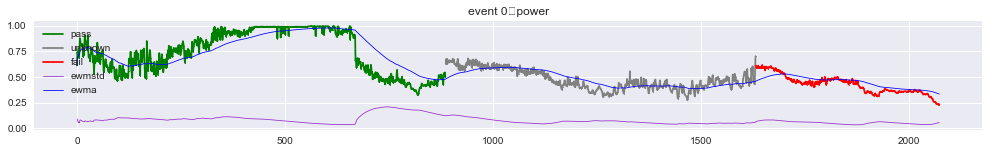

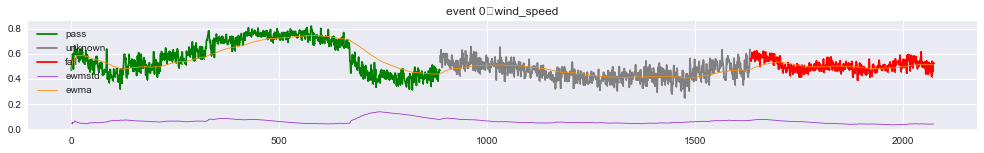

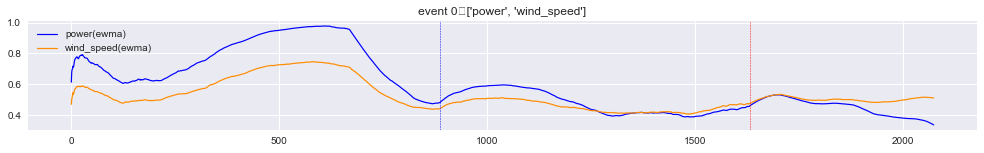

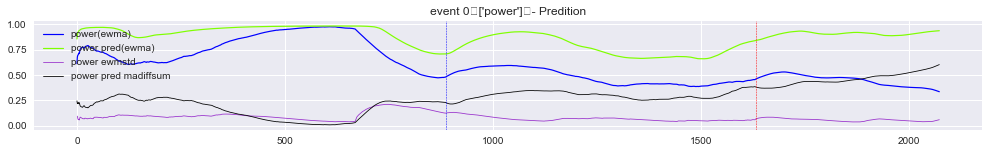

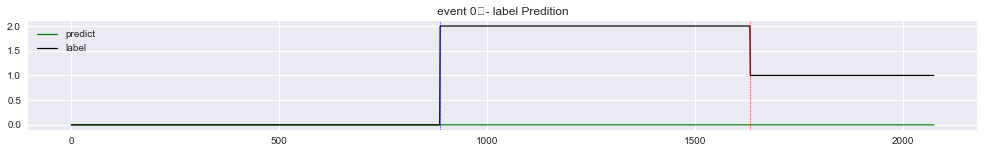

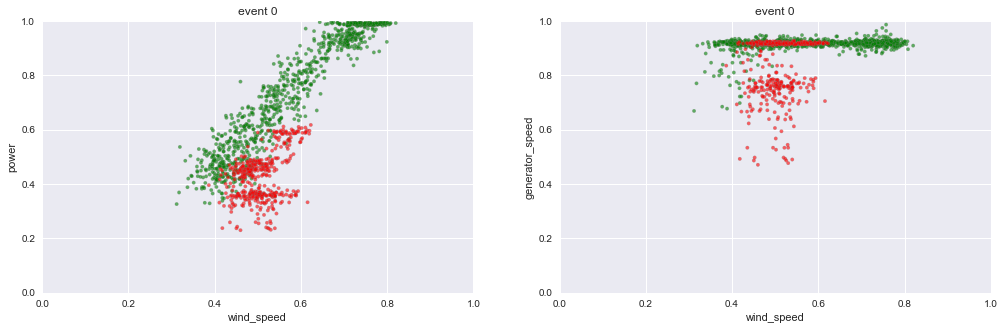

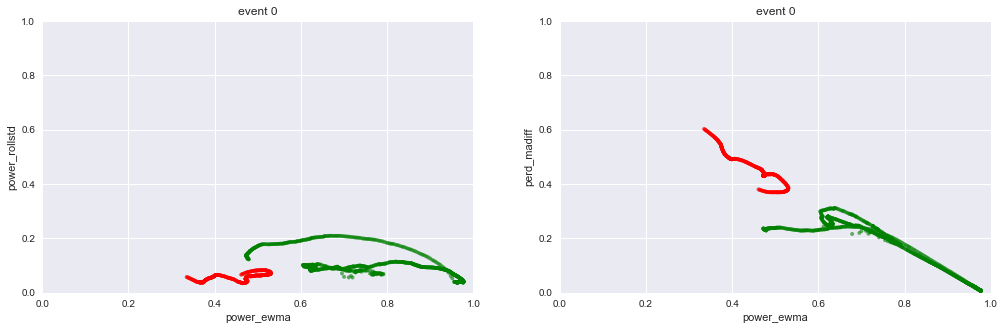

event id: 1


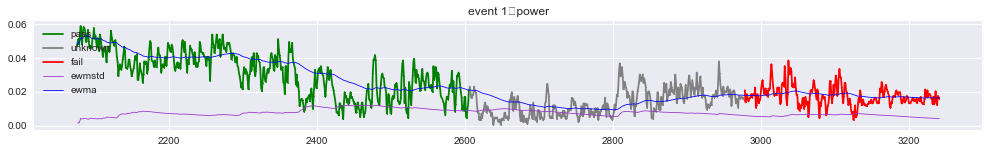

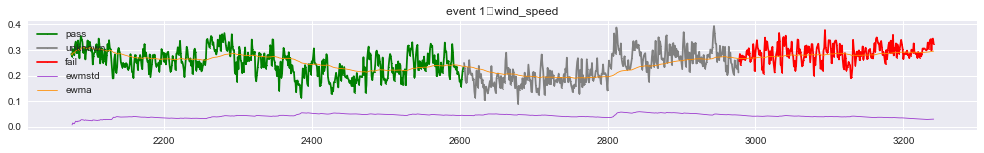

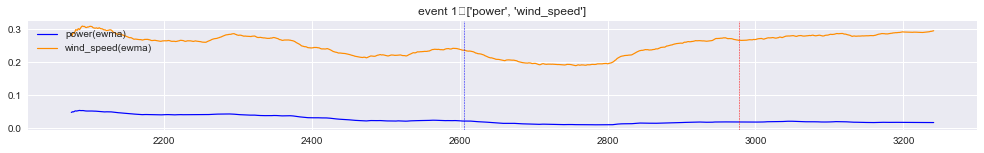

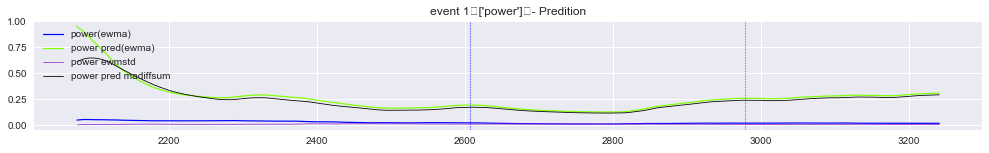

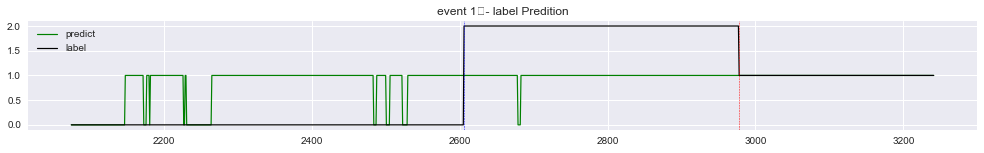

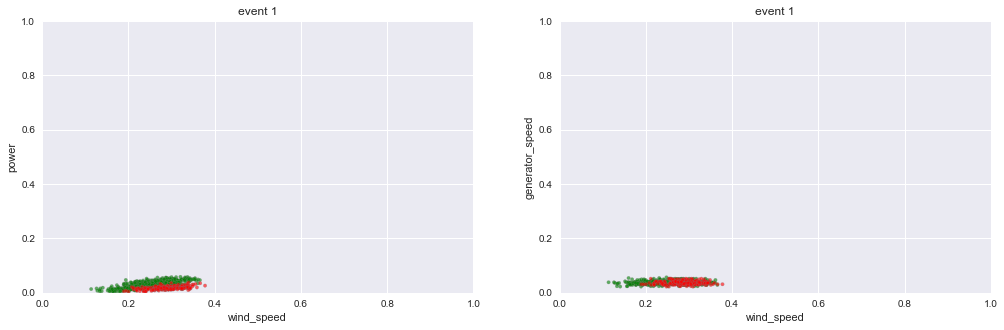

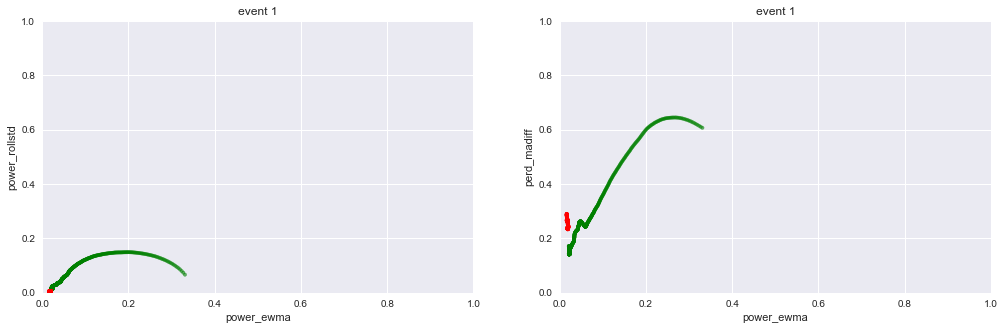

event id: 2


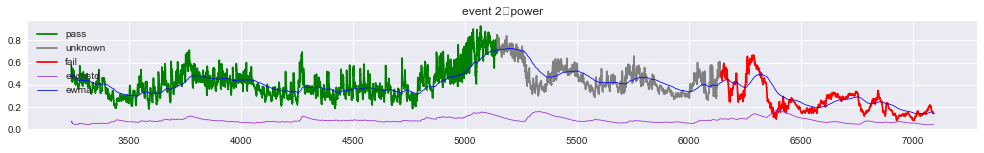

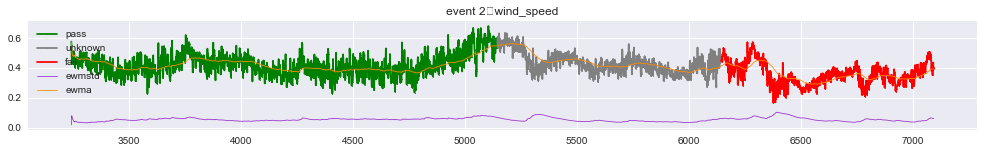

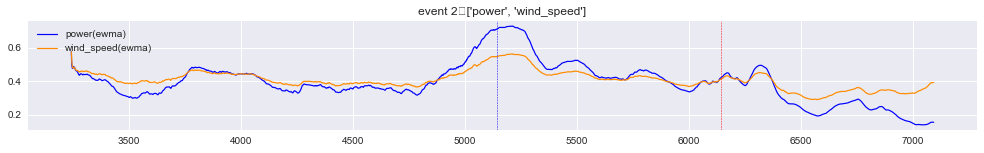

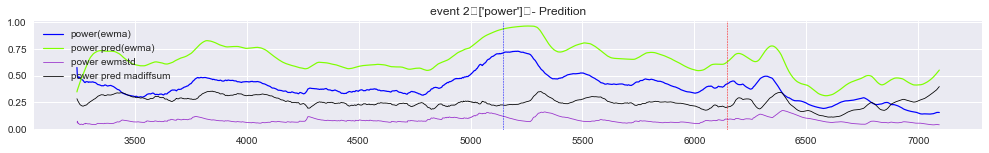

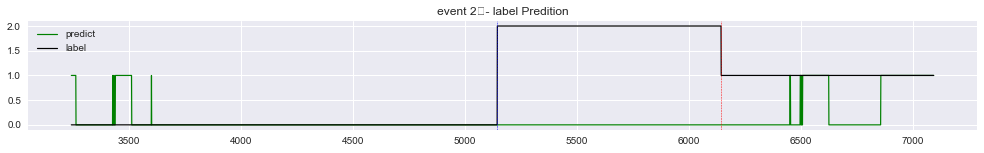

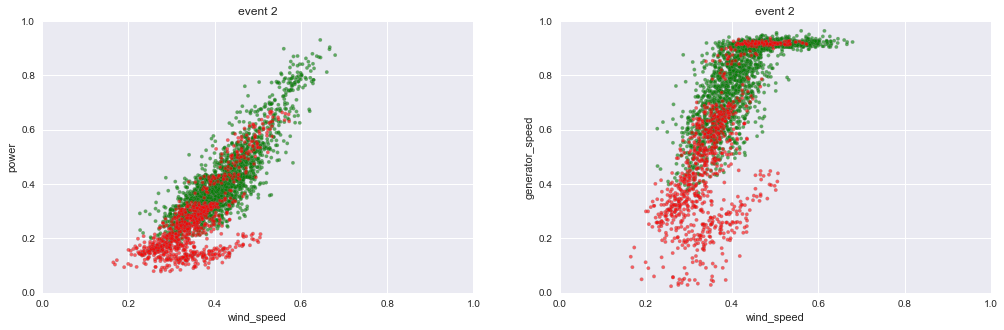

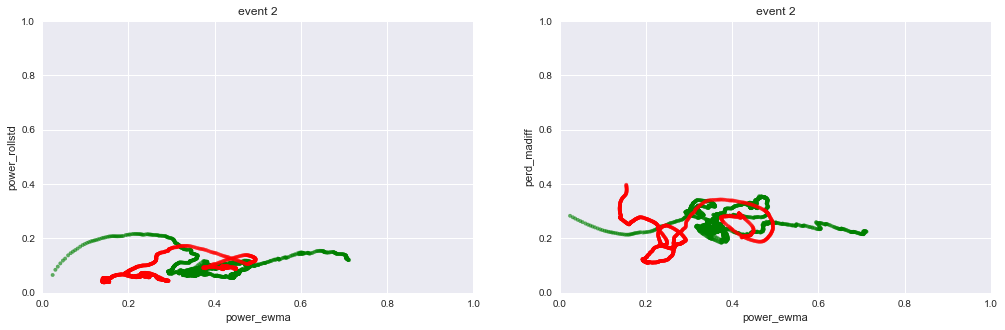

event id: 3


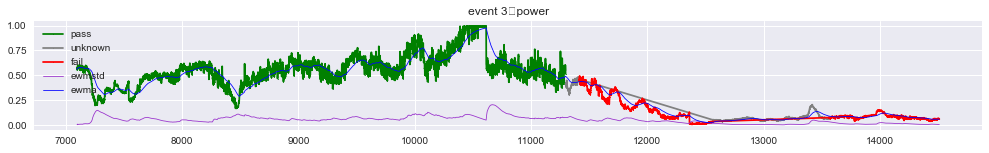

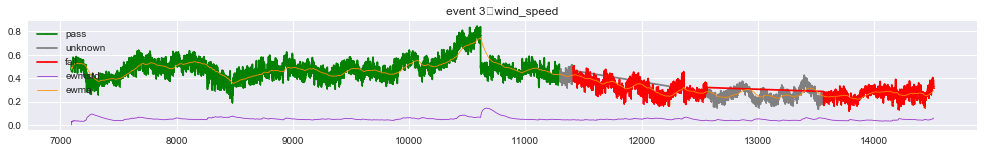

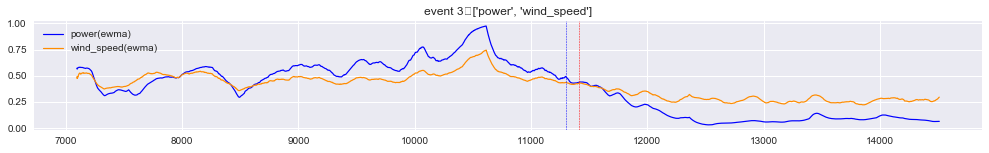

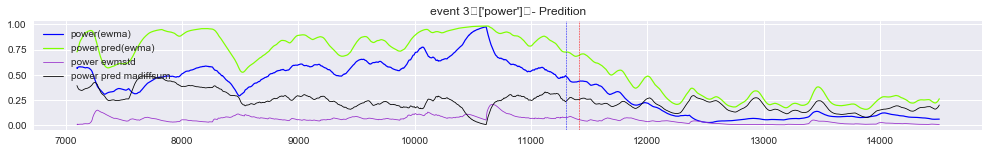

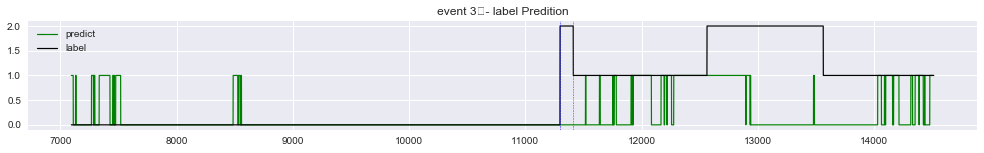

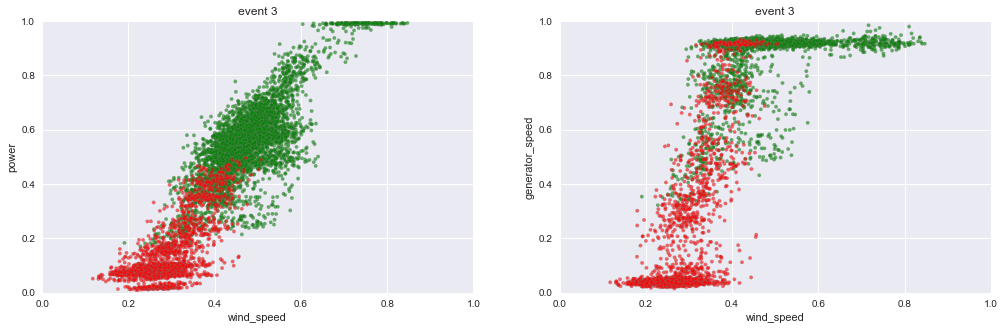

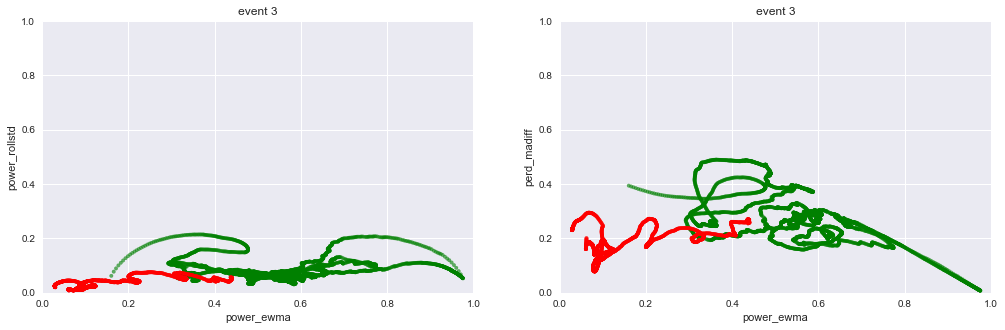

event id: 4


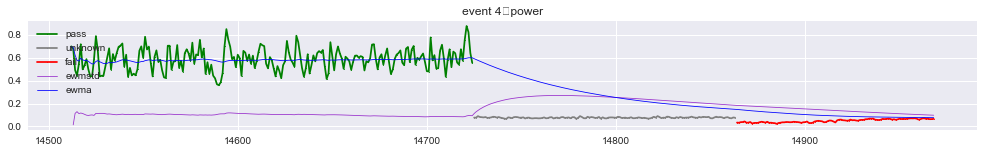

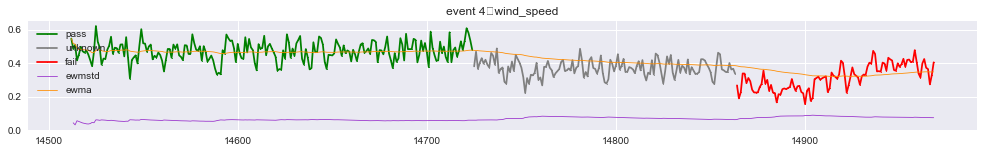

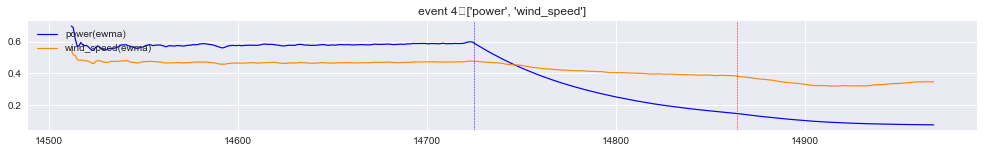

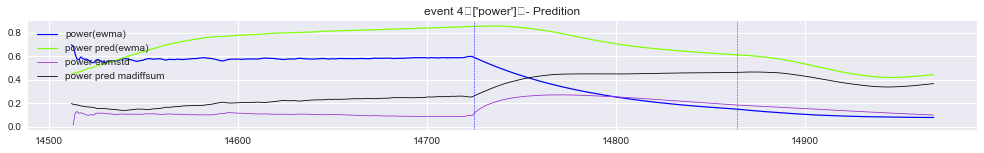

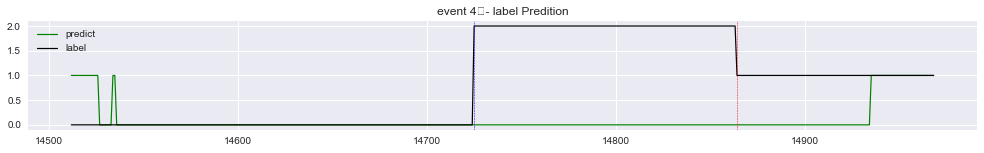

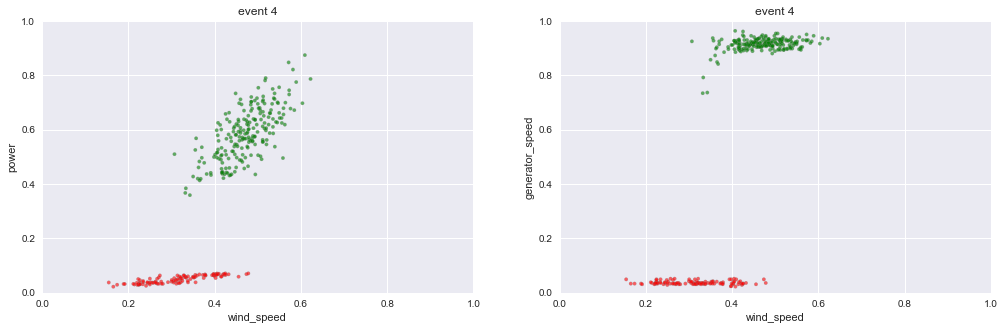

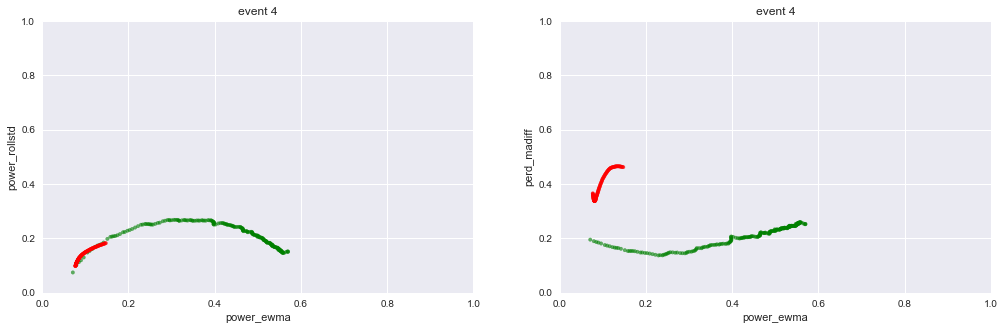

event id: 5


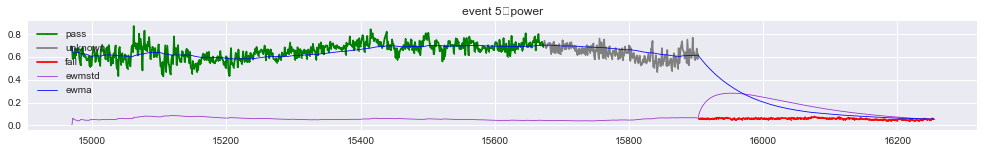

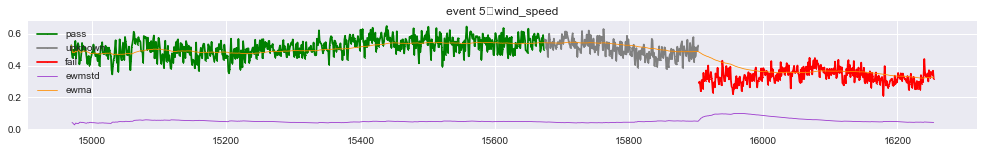

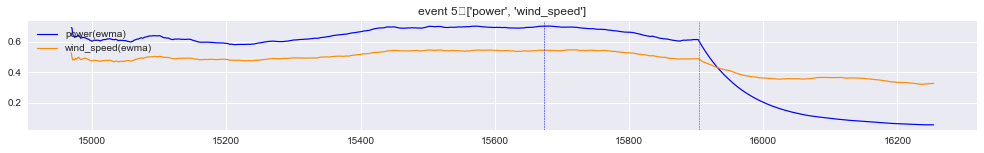

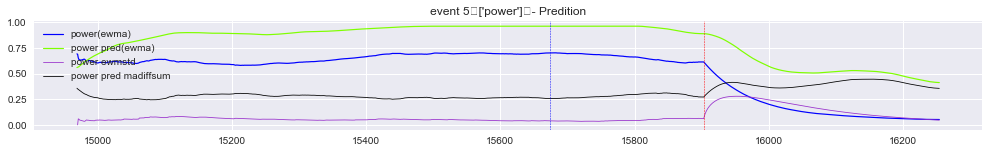

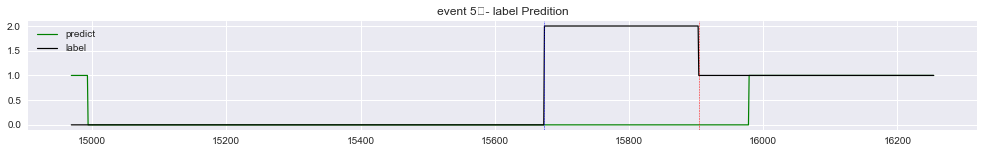

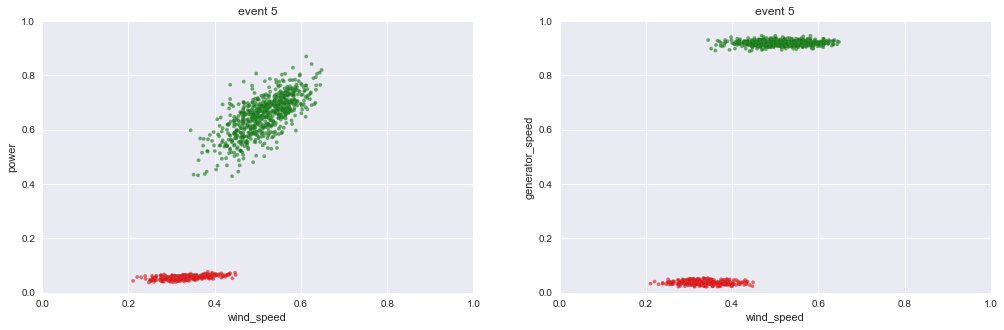

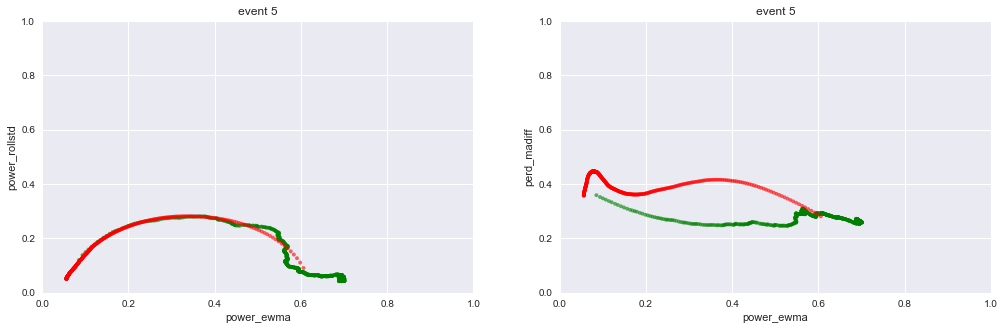

event id: 6


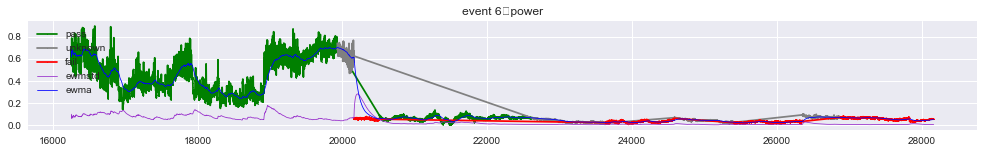

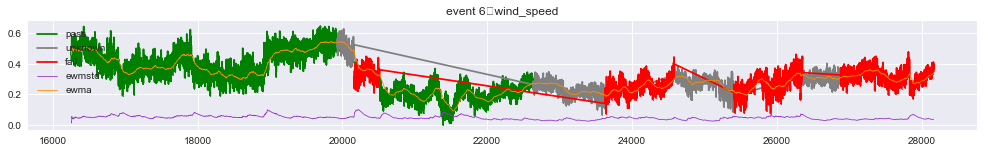

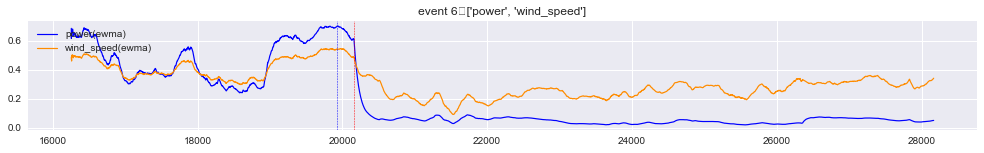

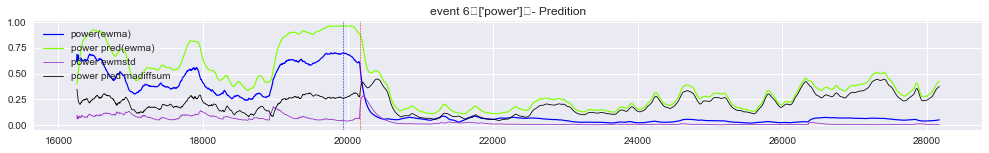

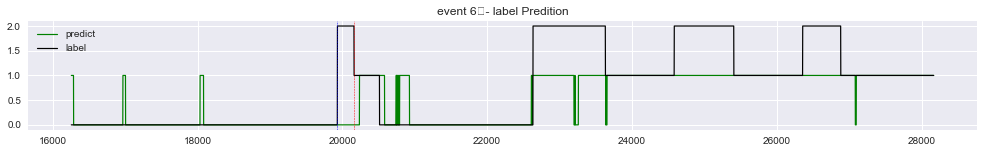

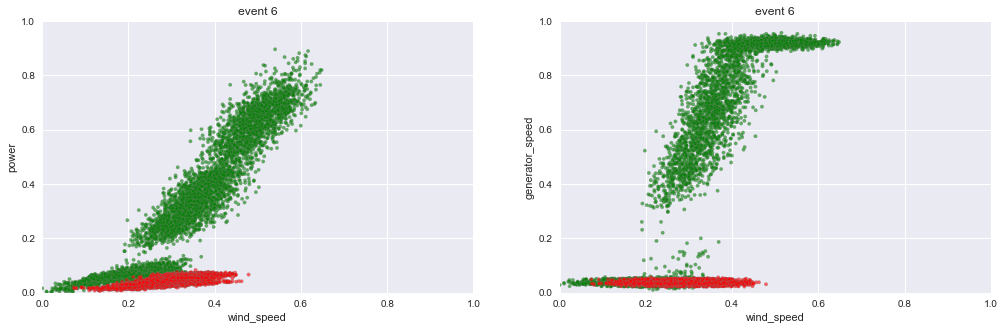

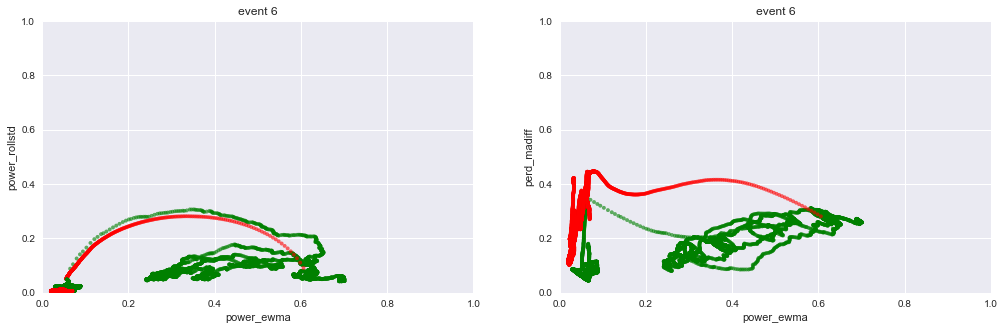

event id: 7


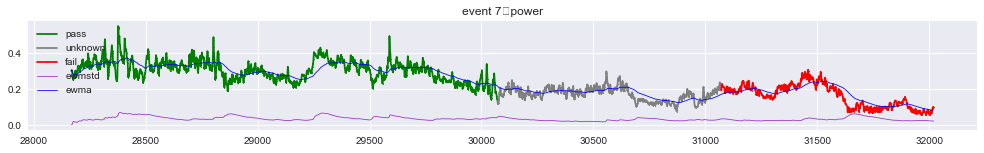

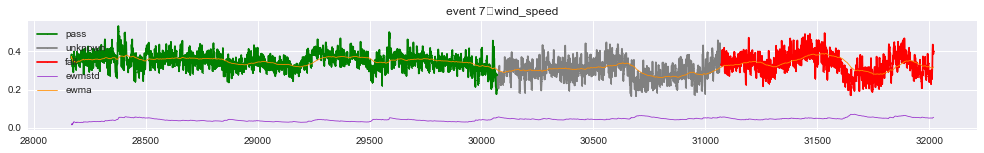

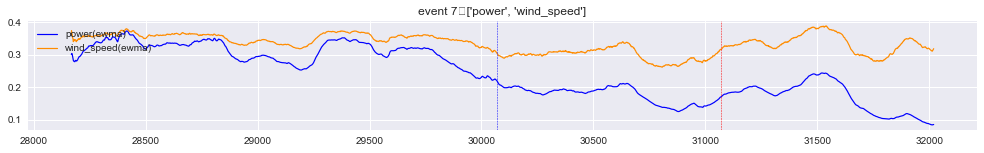

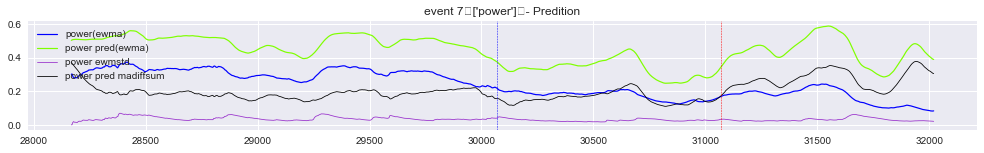

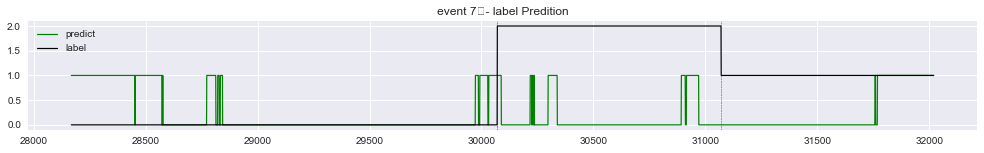

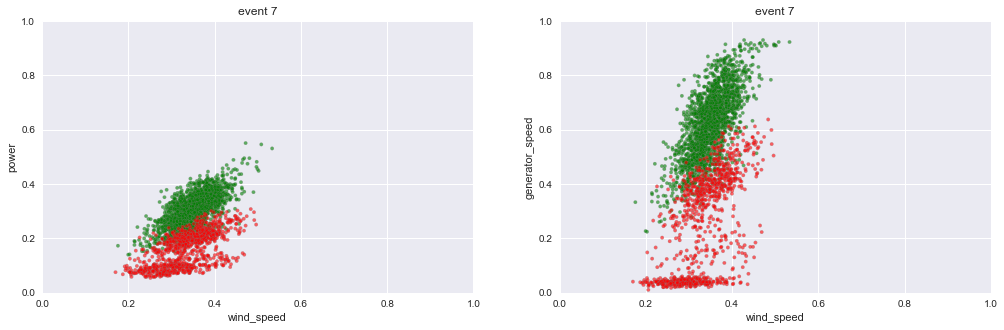

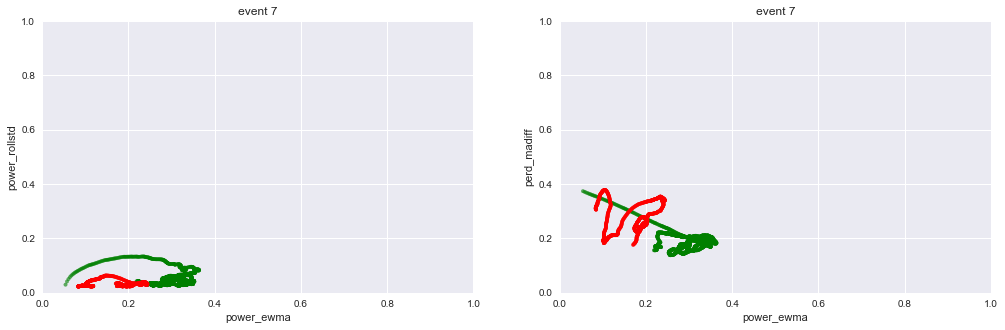

event id: 8


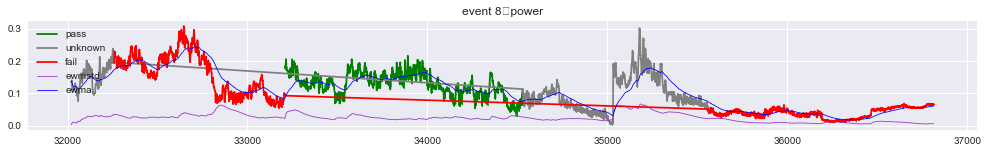

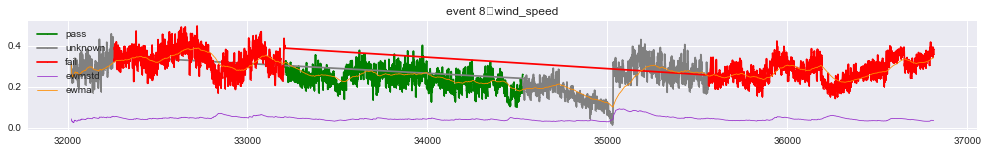

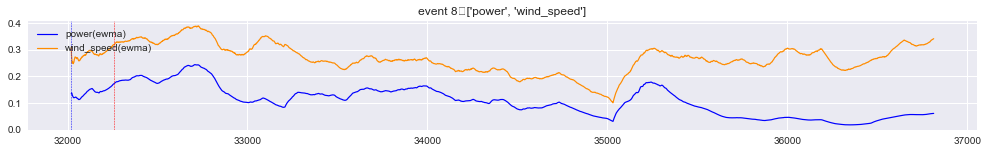

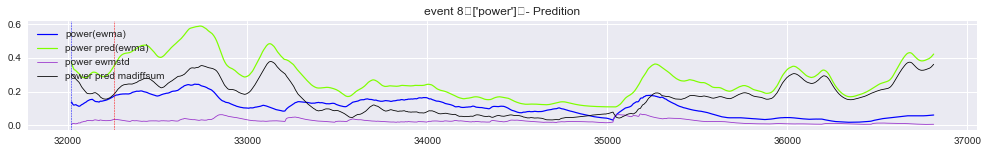

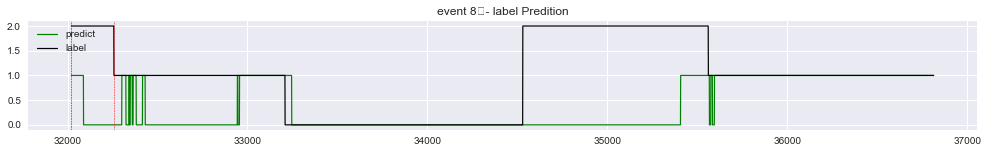

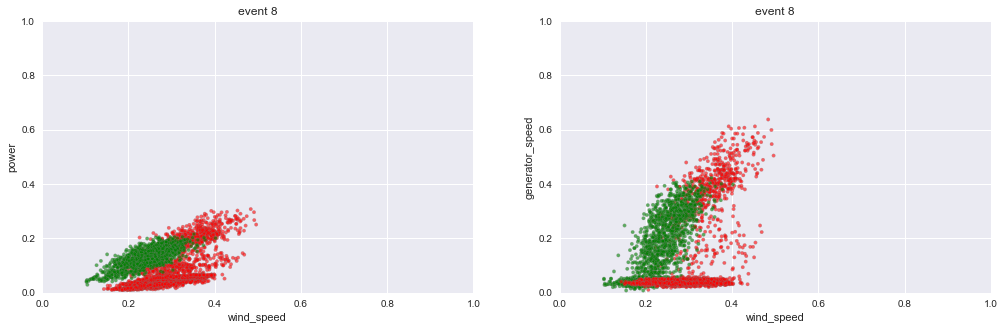

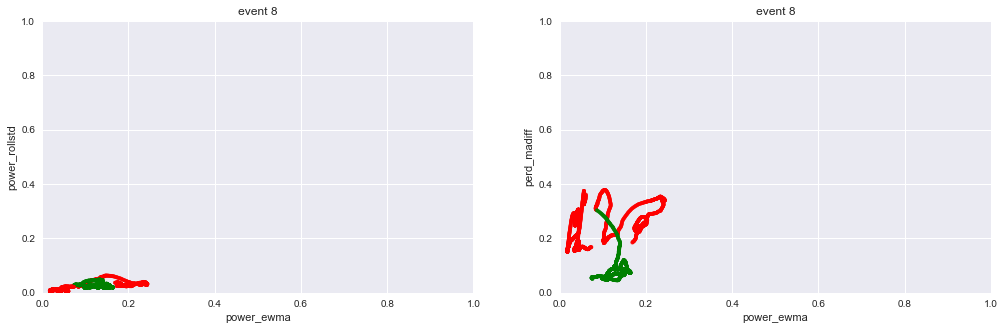

event id: 9


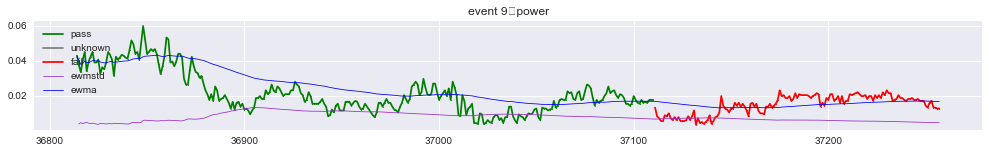

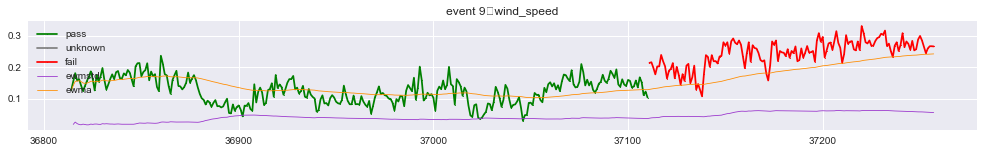

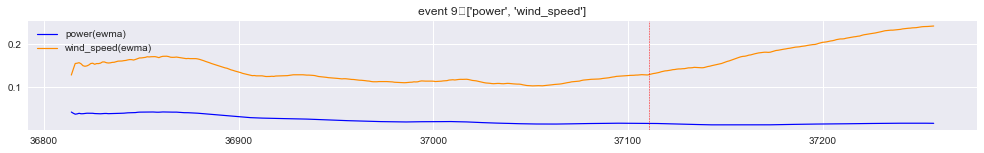

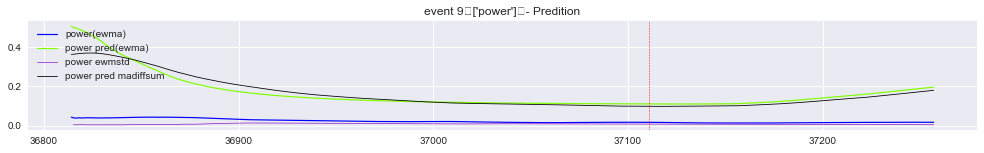

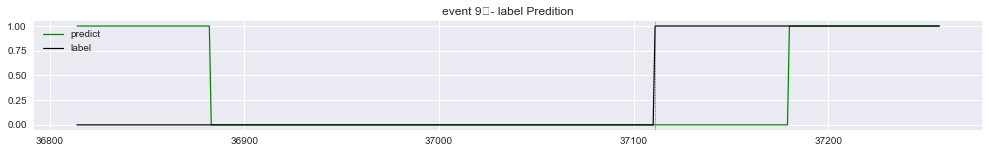

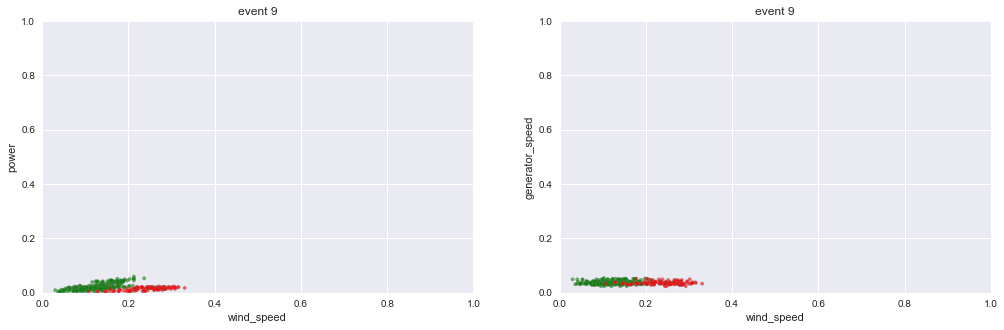

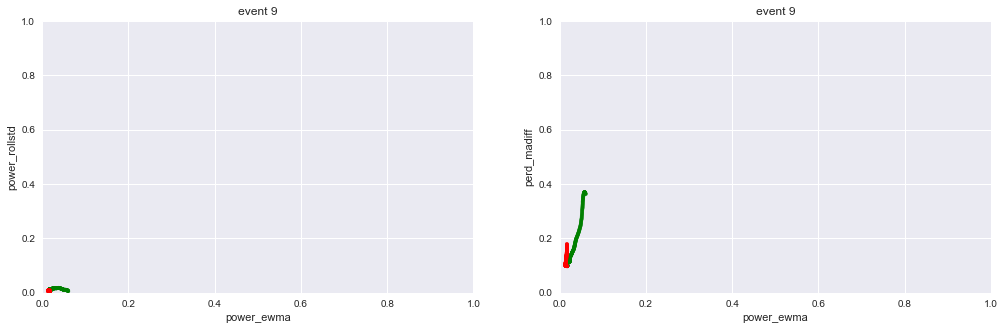

event id: 10


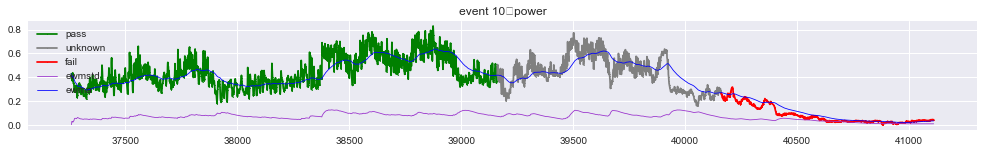

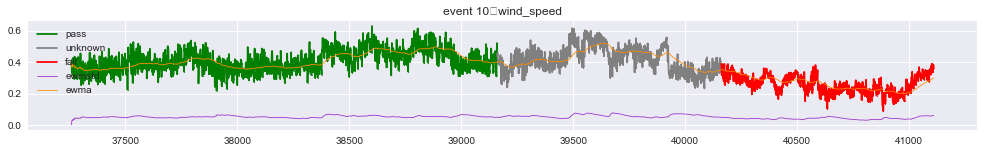

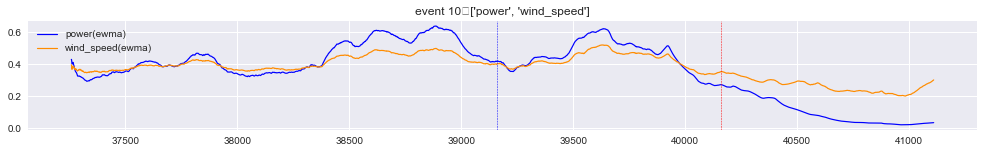

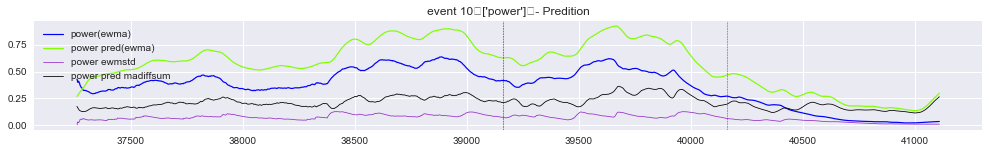

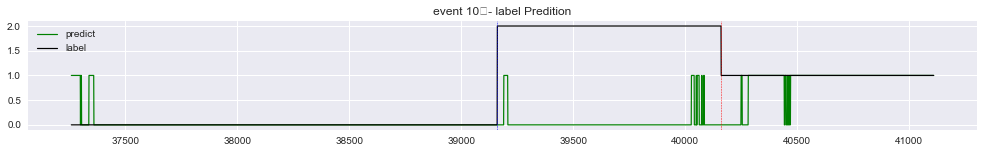

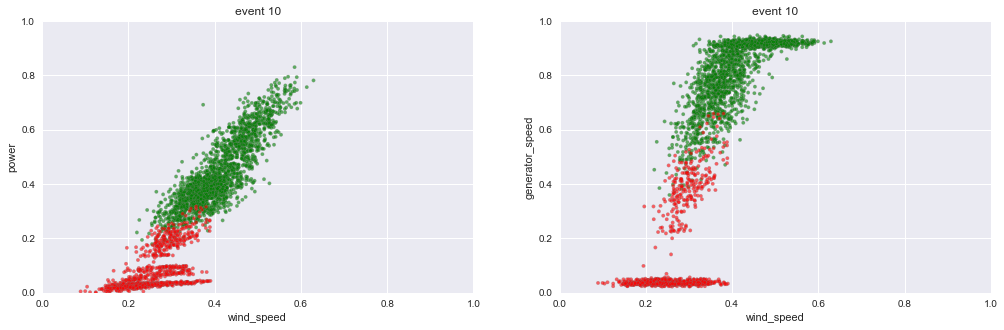

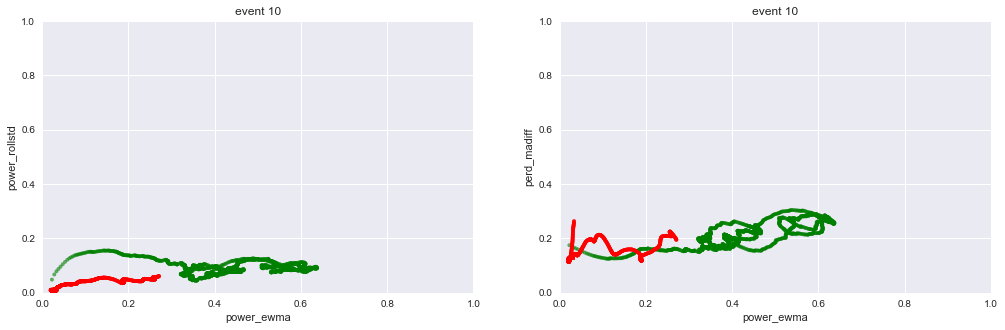

event id: 11


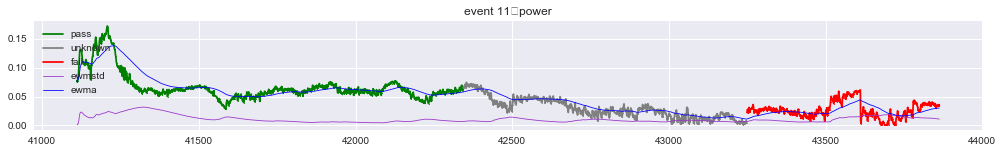

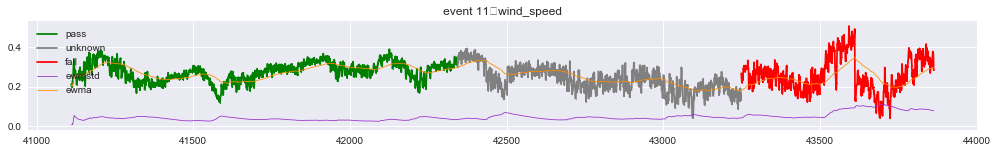

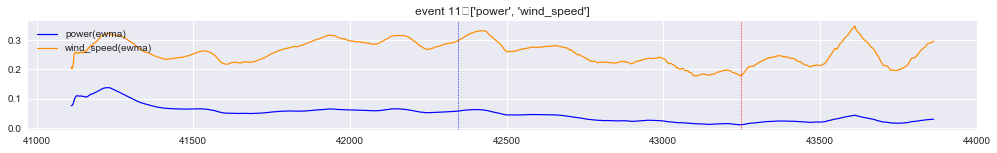

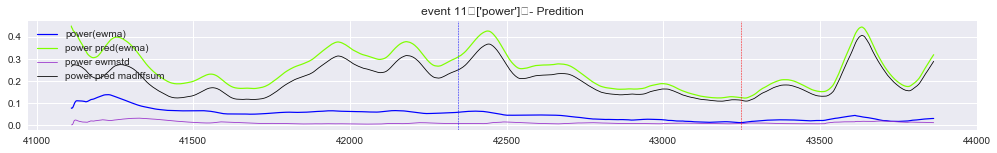

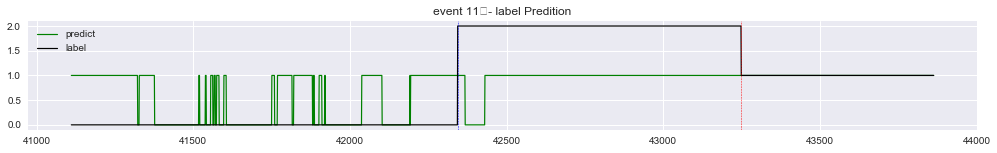

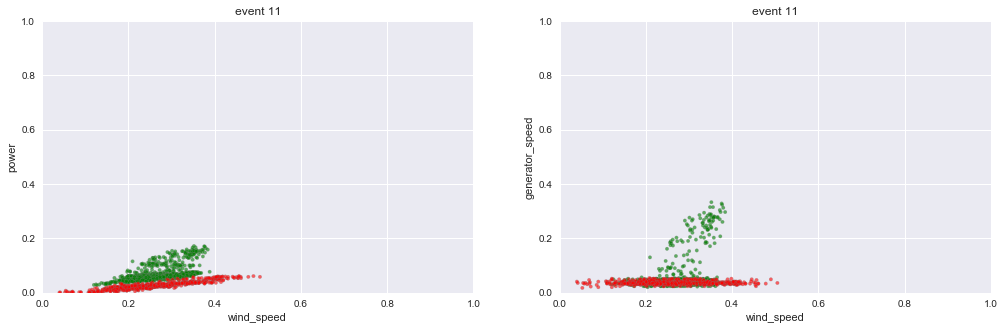

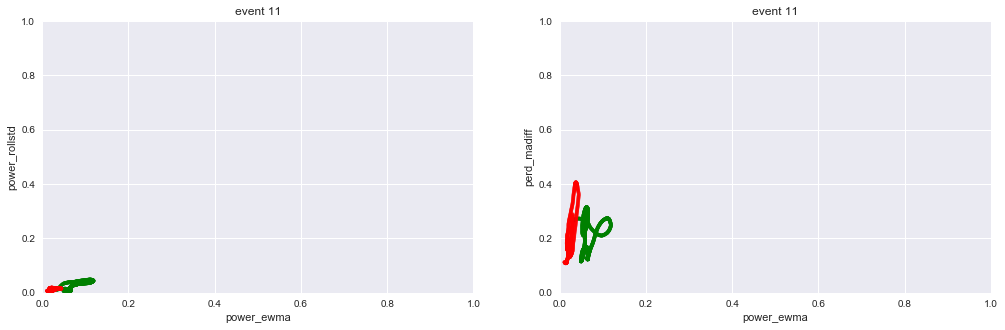

event id: 12


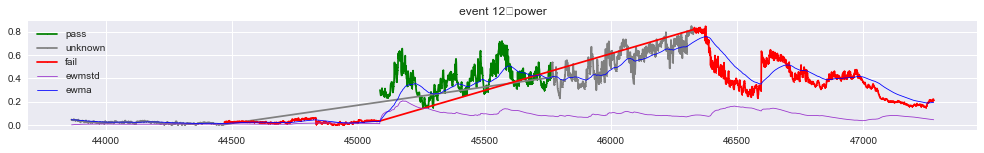

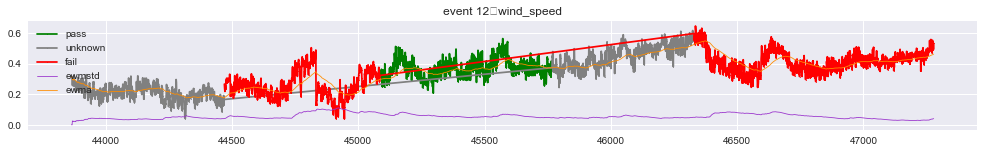

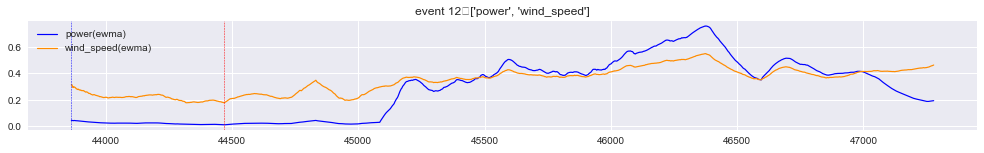

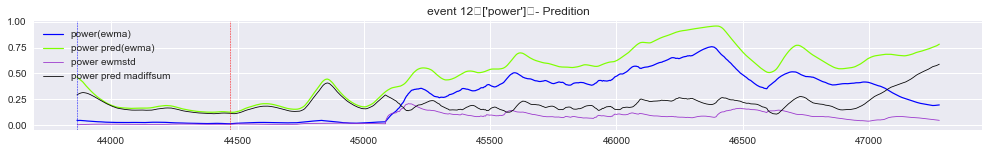

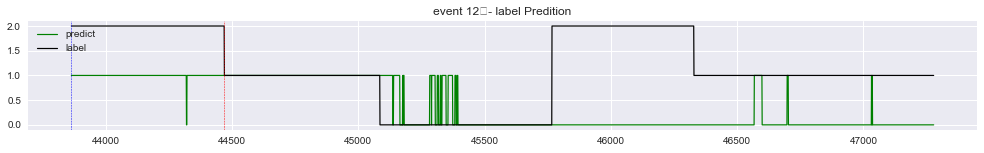

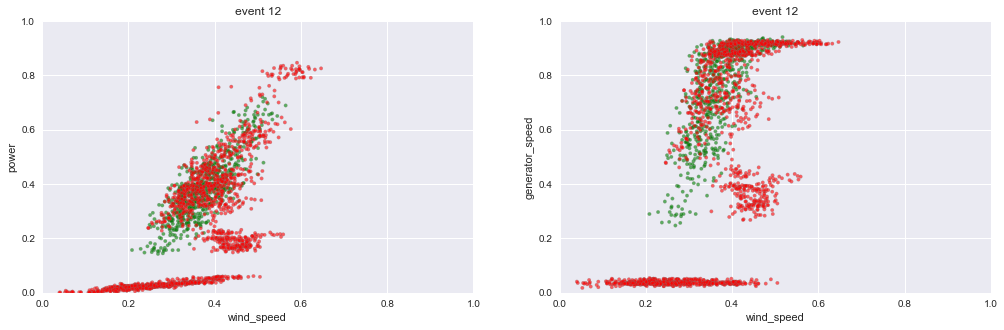

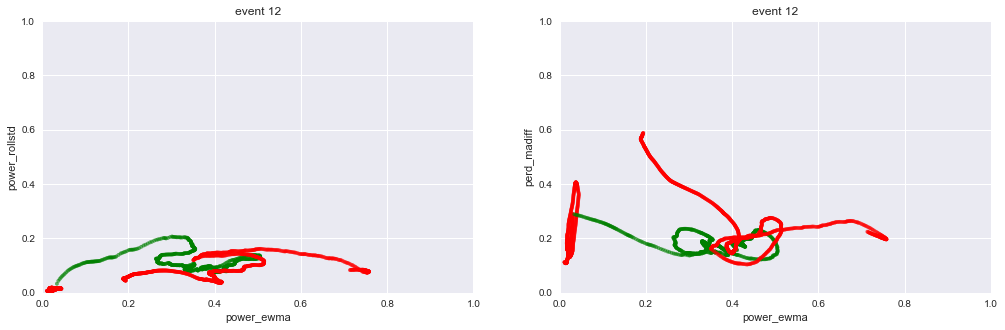

event id: 13


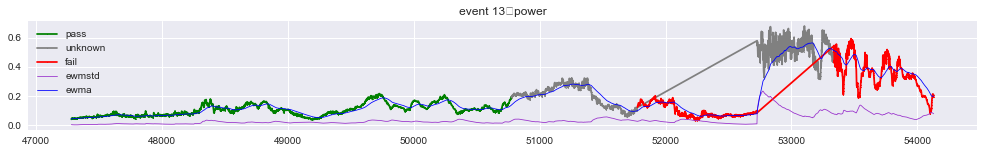

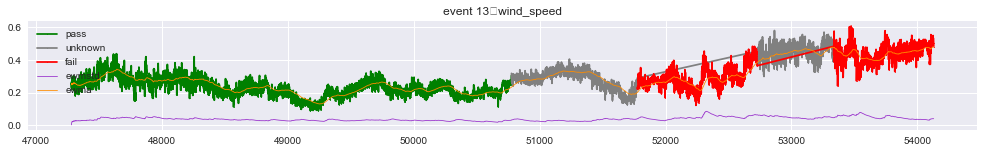

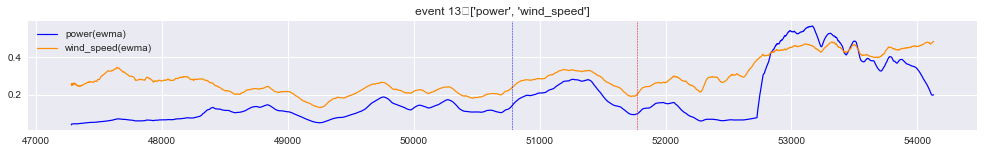

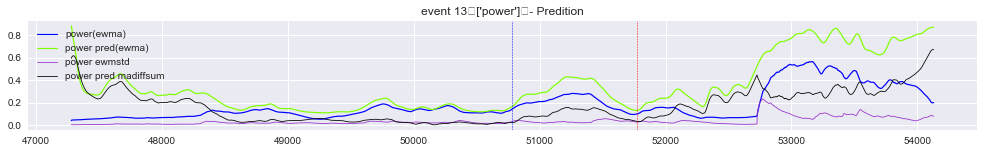

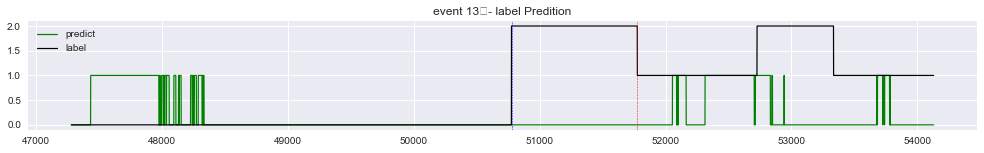

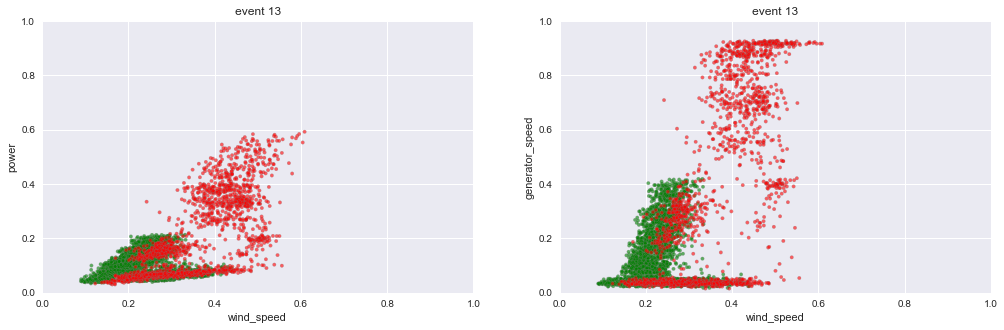

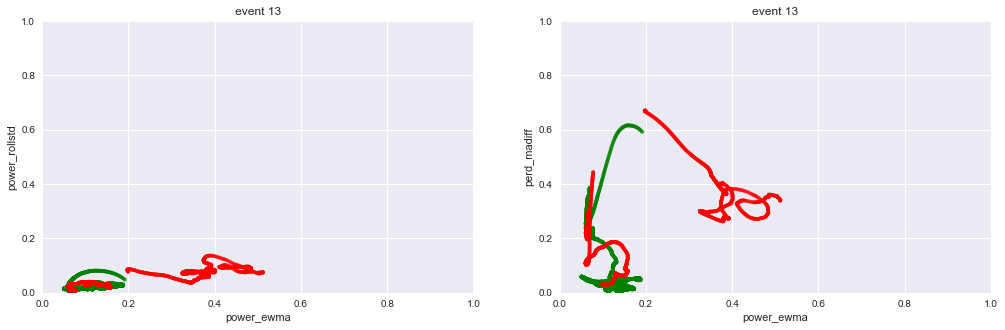

event id: 14


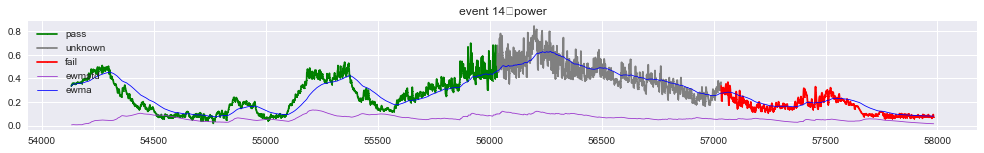

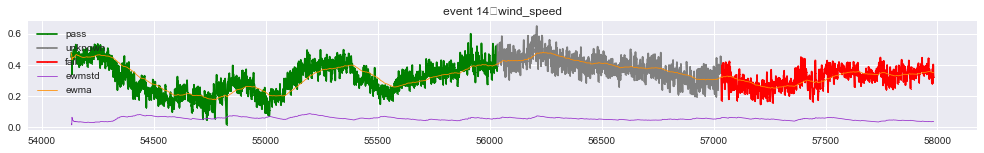

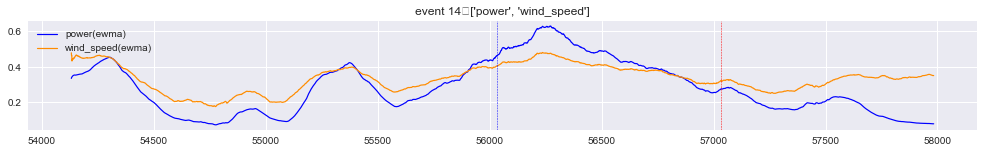

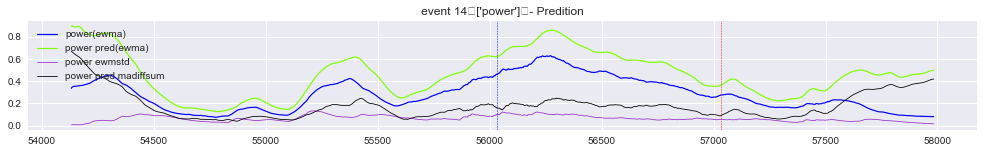

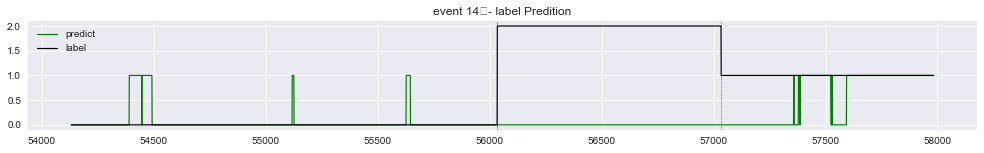

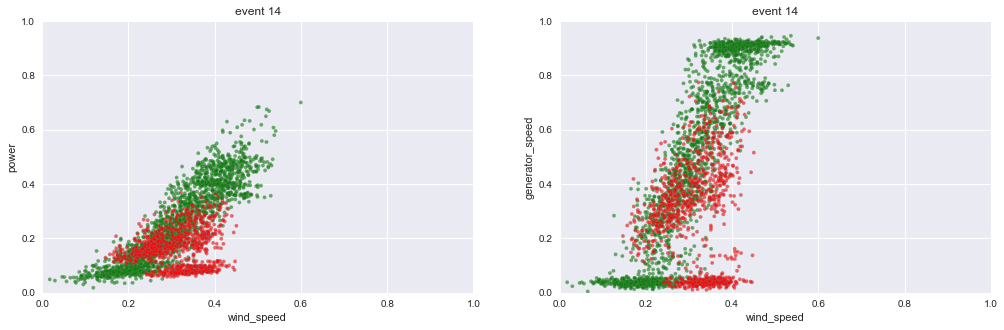

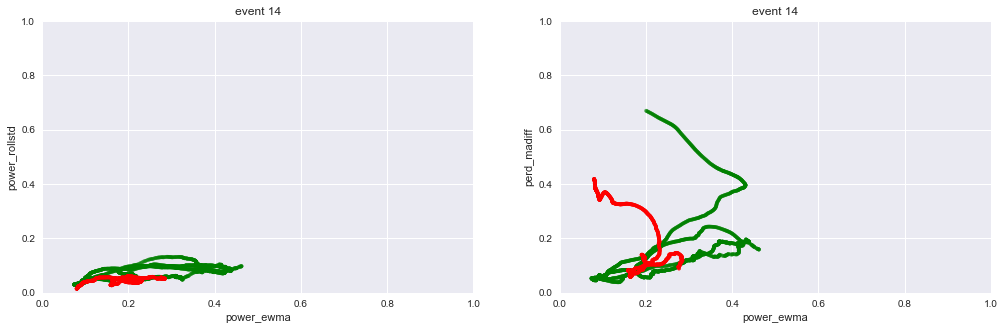

event id: 15


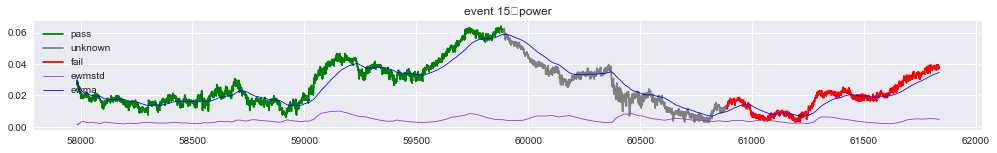

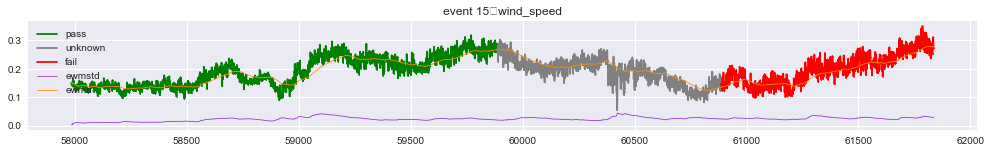

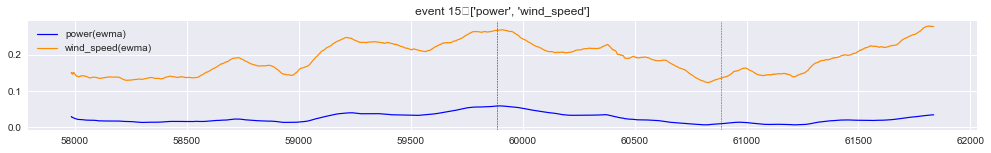

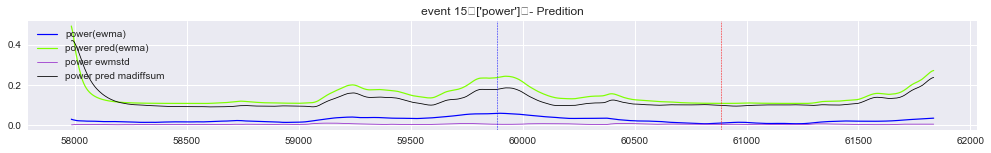

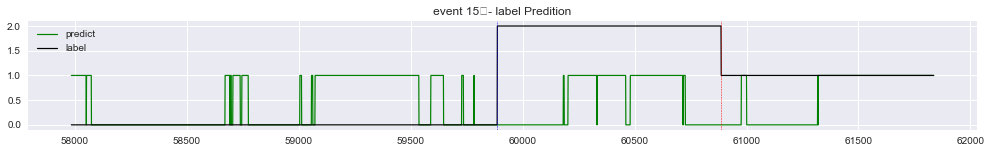

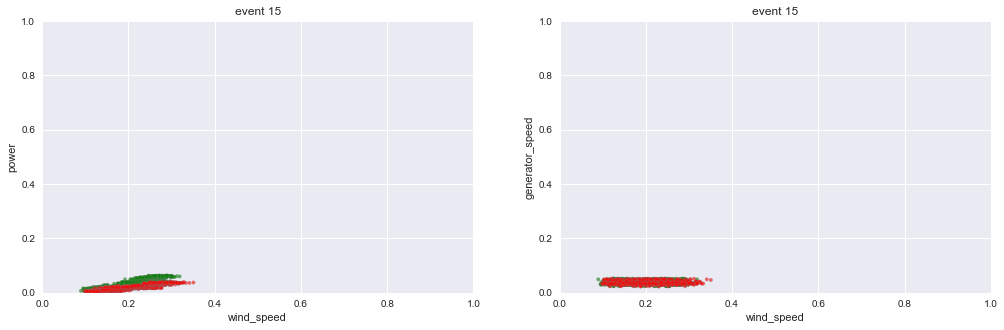

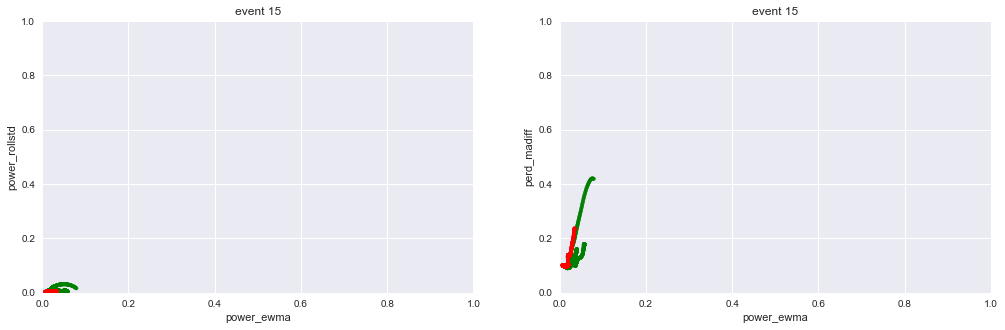

event id: 16


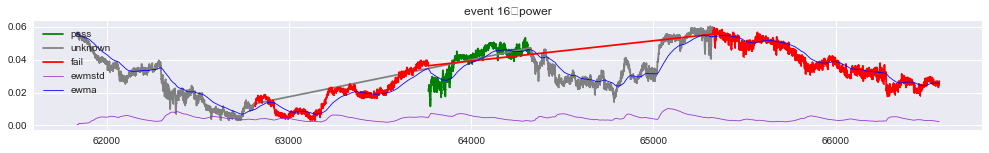

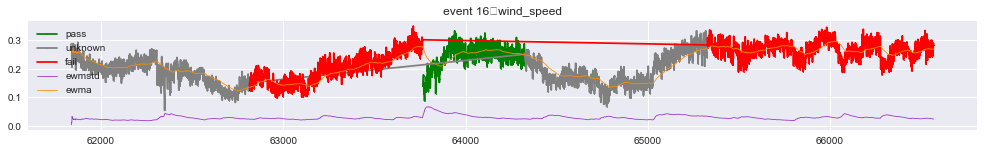

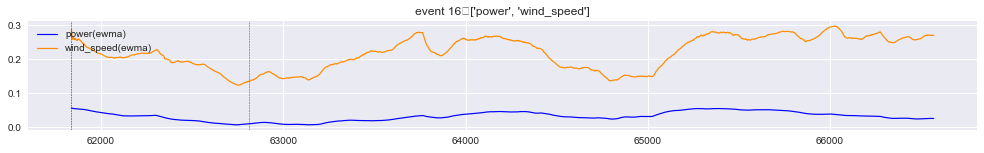

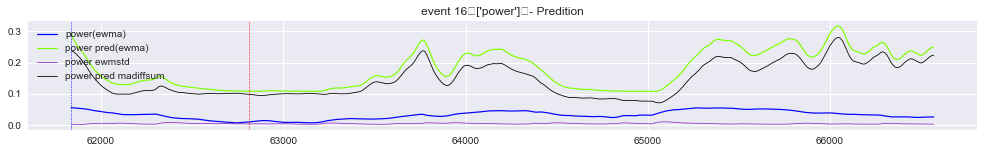

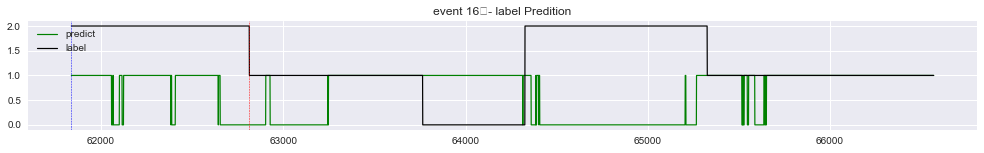

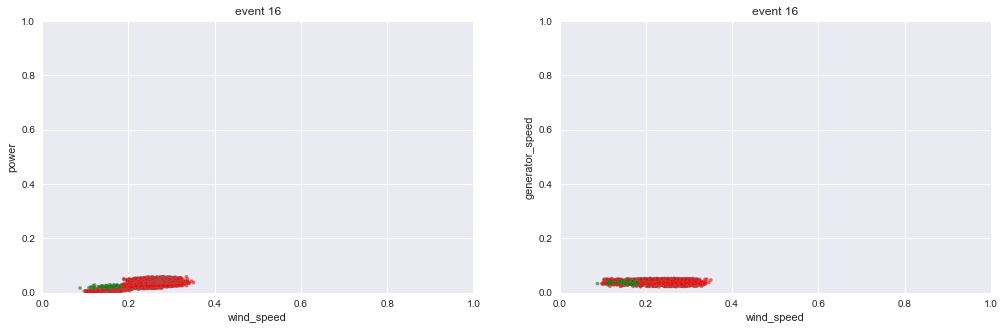

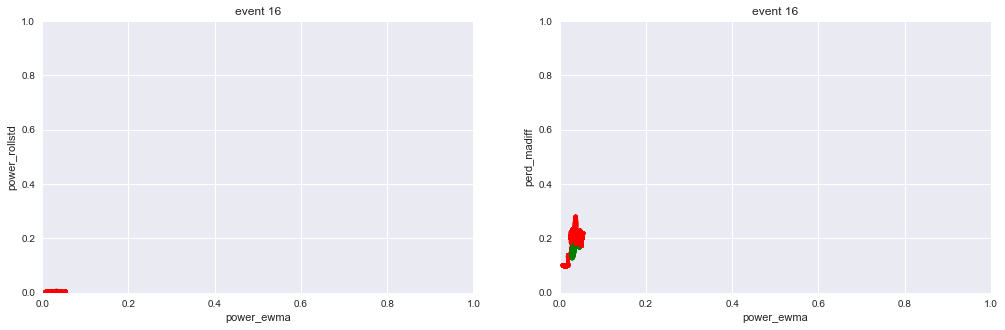

event id: 17


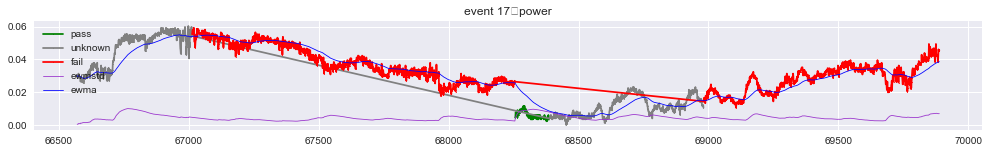

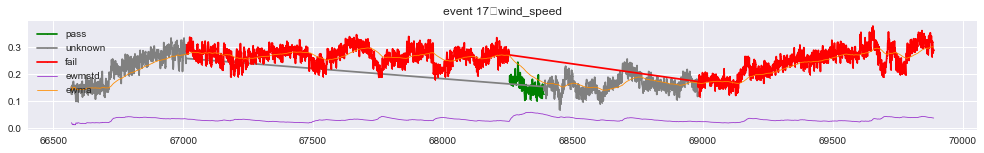

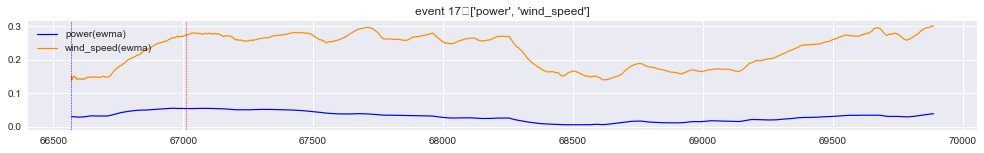

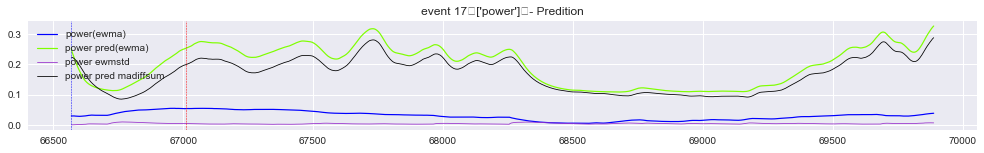

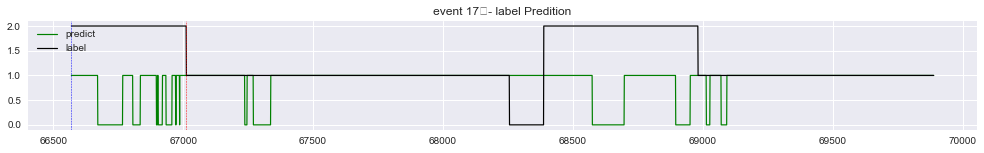

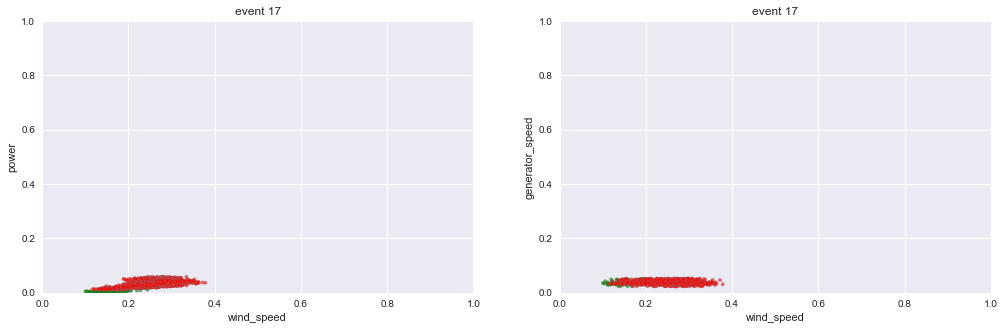

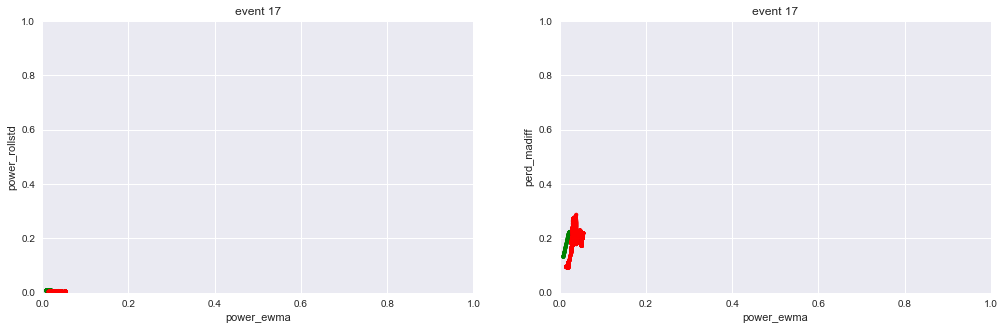

event id: 18


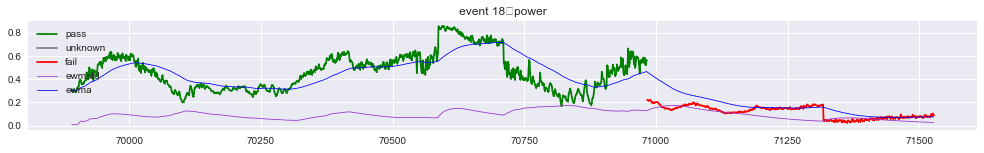

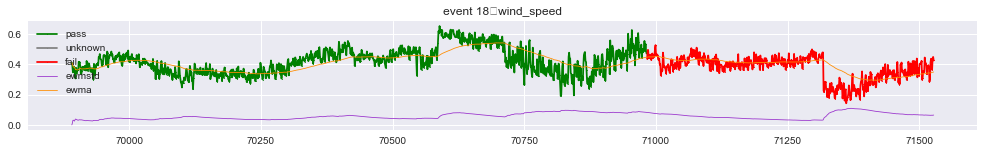

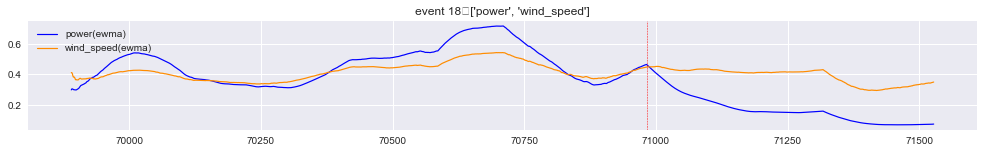

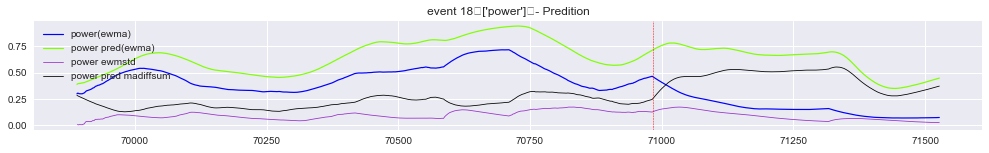

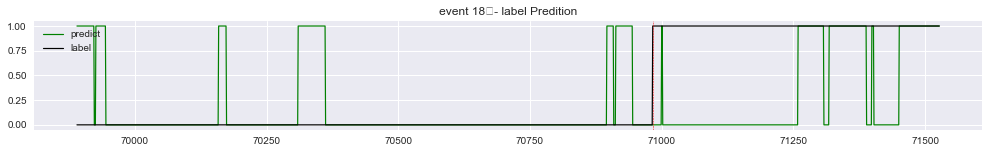

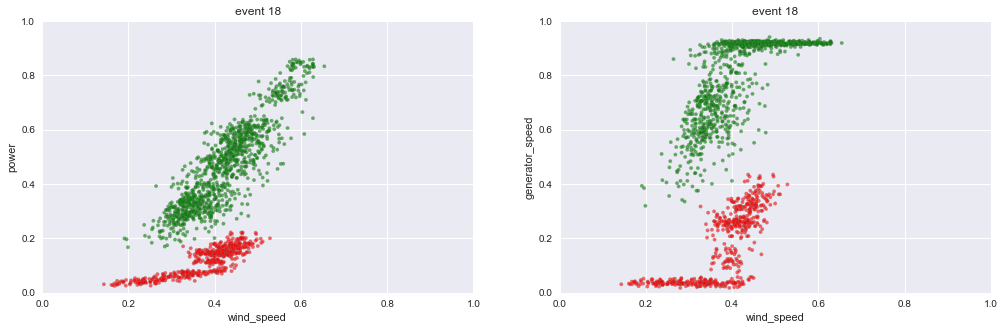

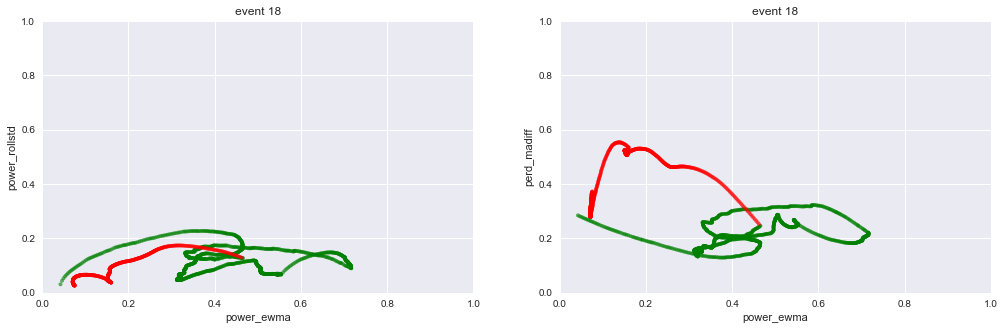

event id: 19


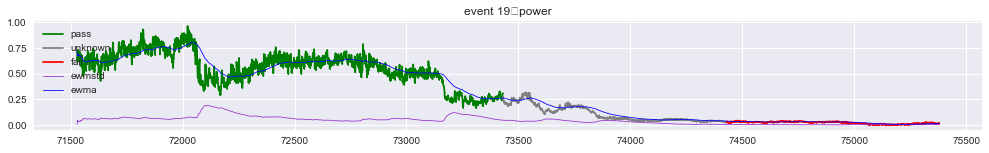

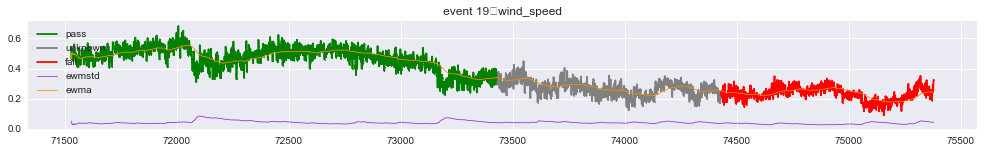

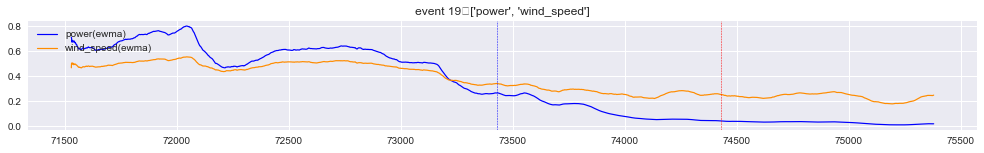

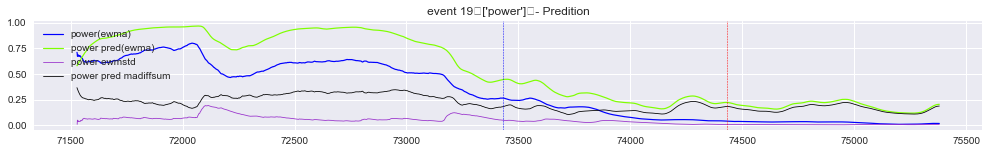

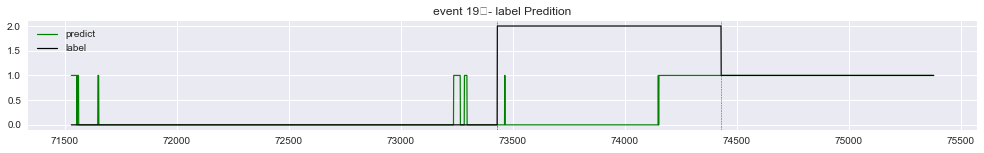

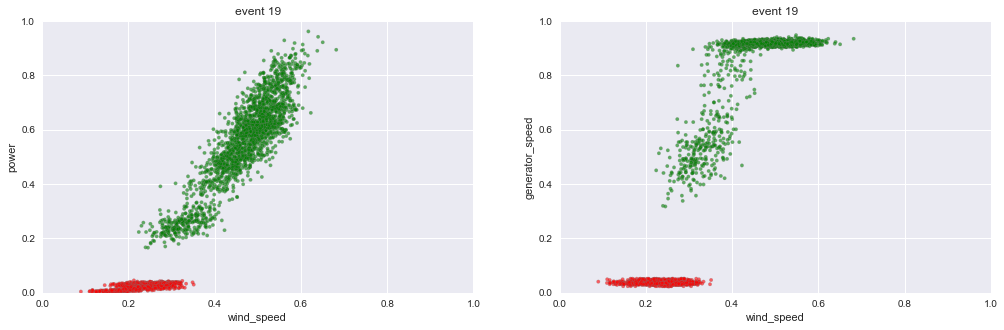

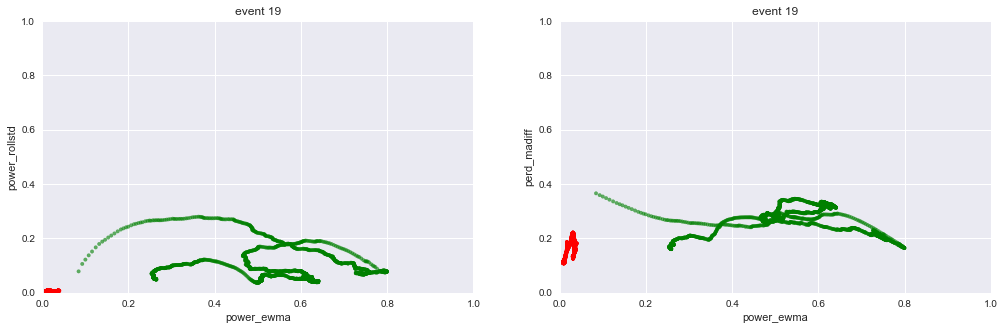

event id: 20


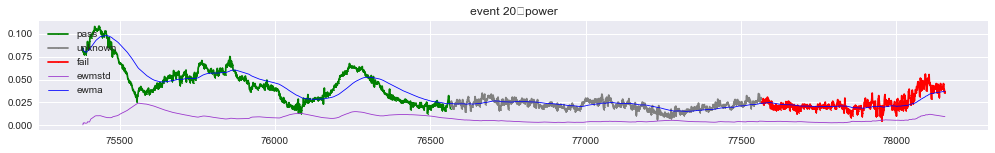

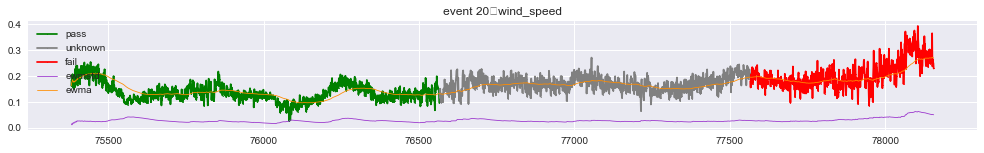

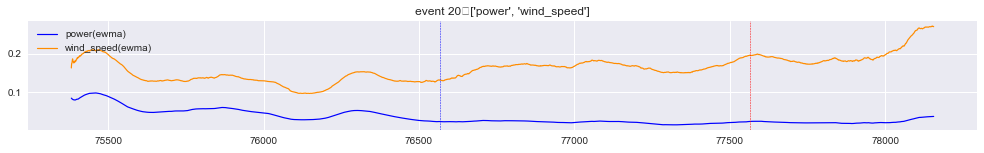

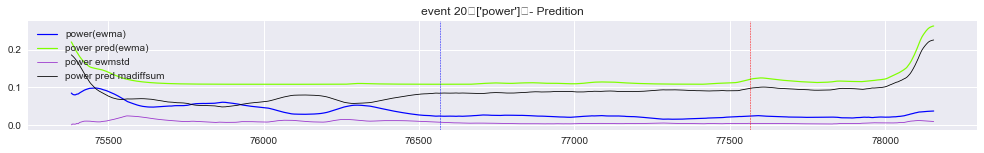

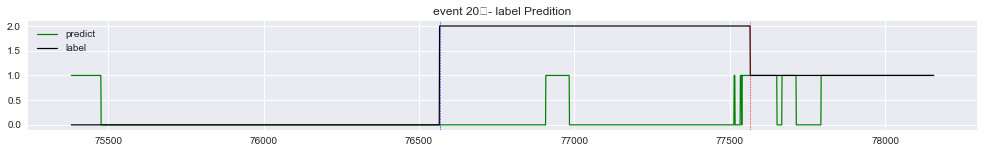

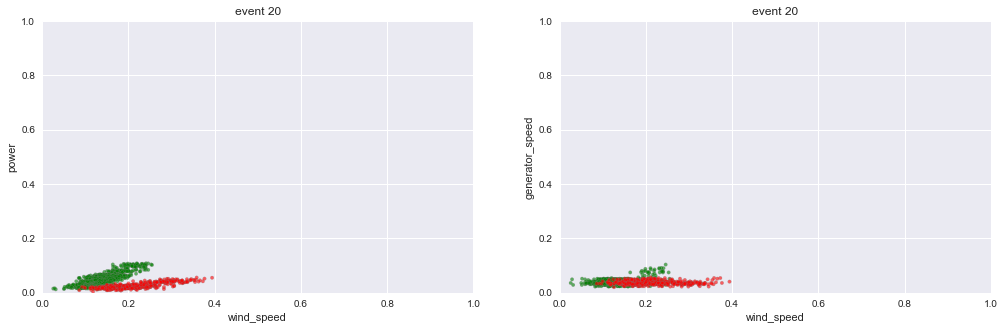

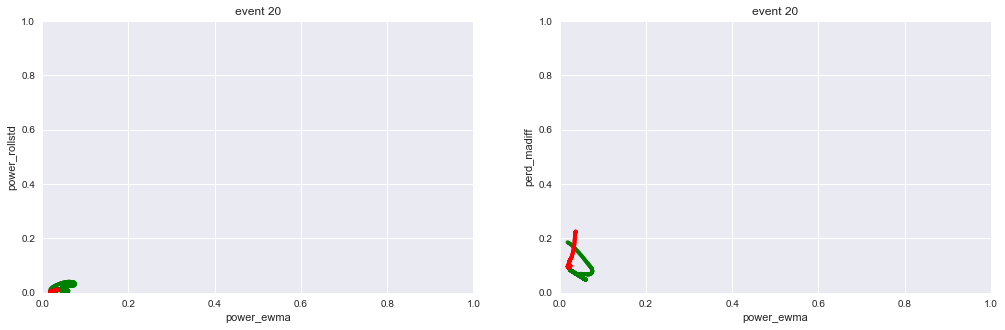

event id: 21


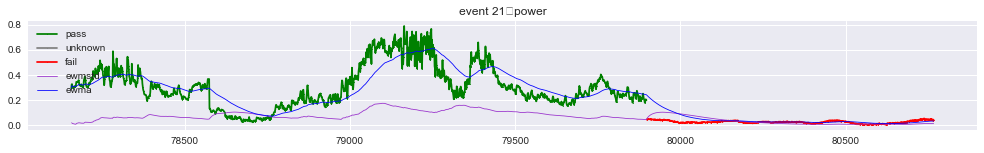

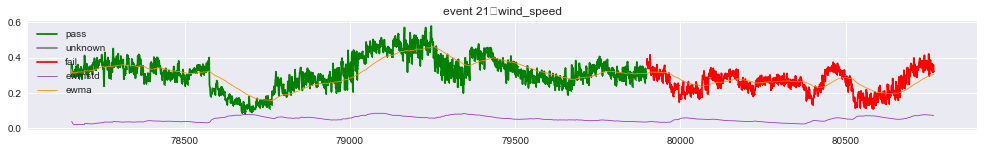

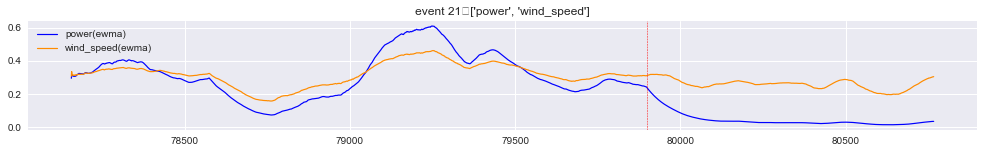

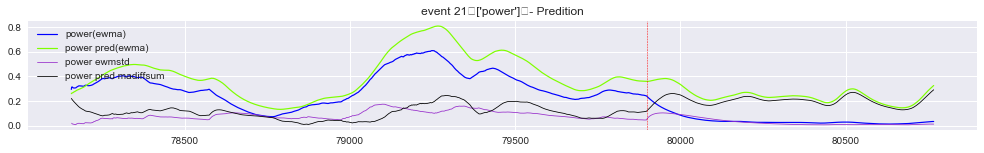

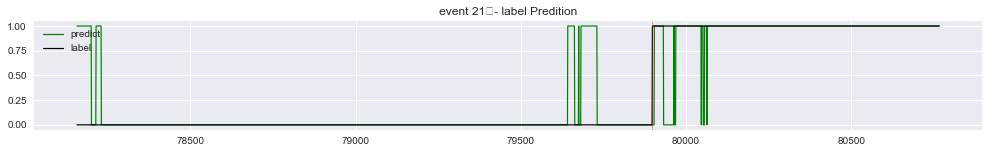

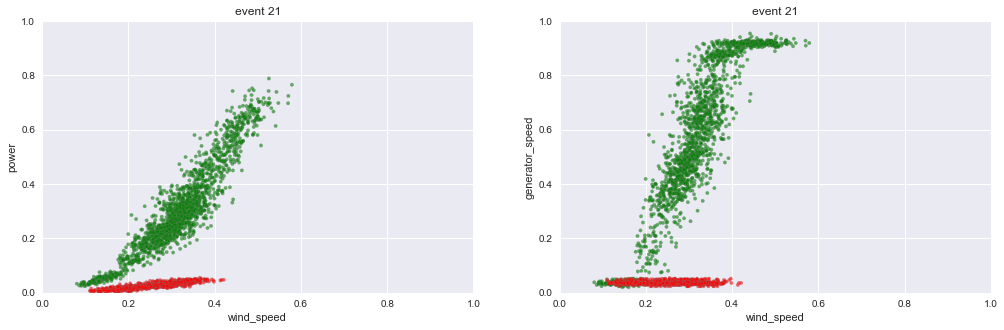

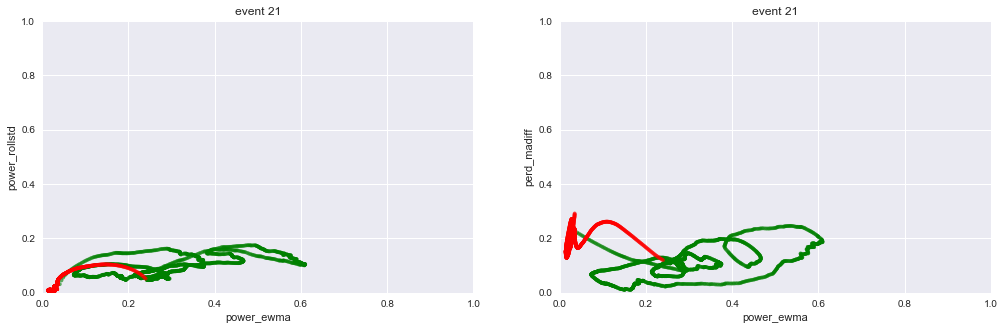

event id: 22


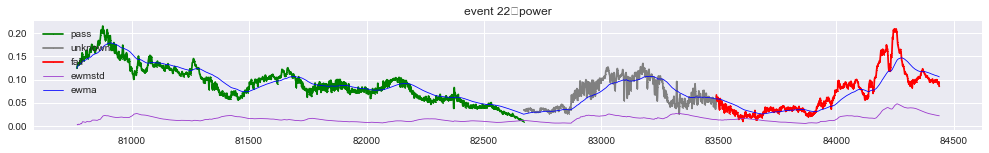

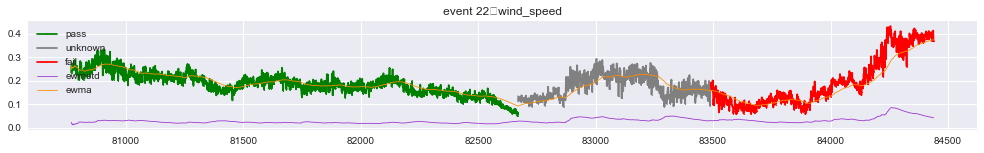

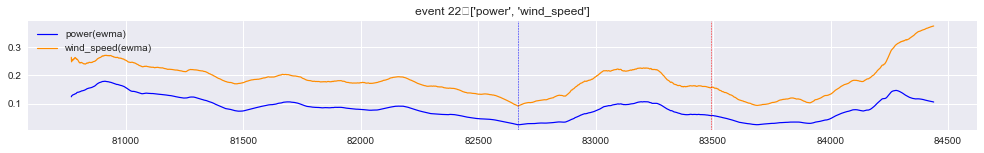

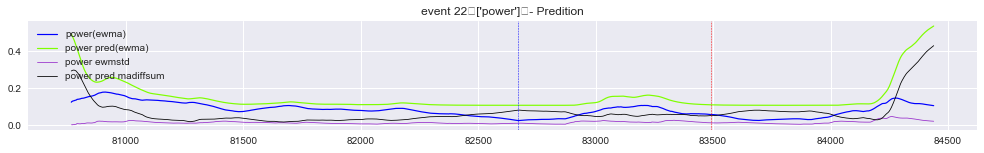

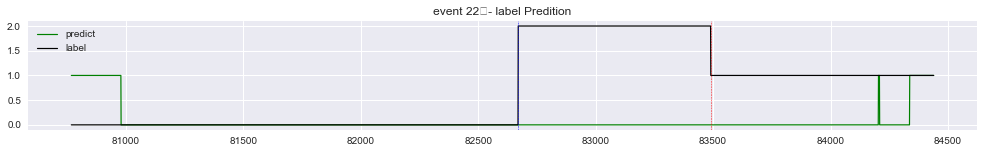

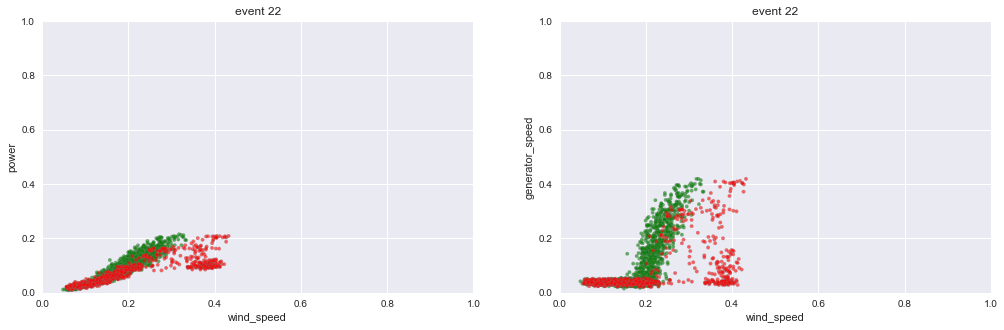

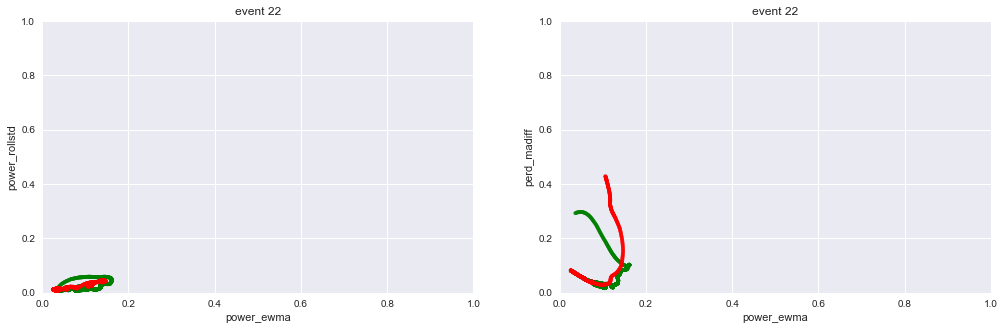

event id: 23


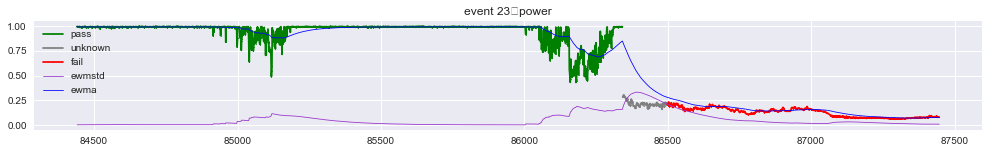

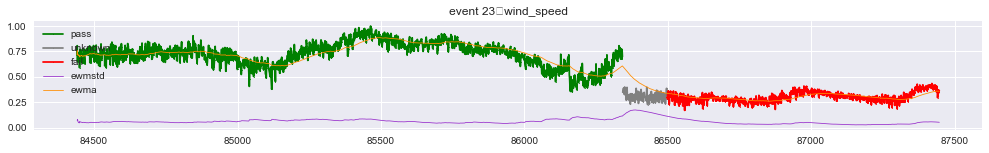

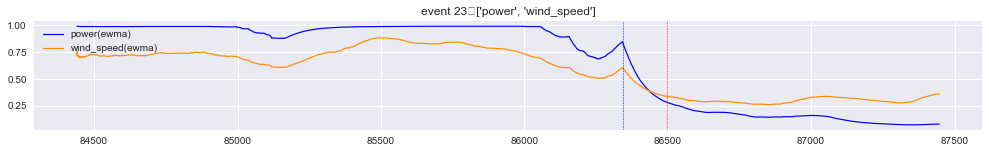

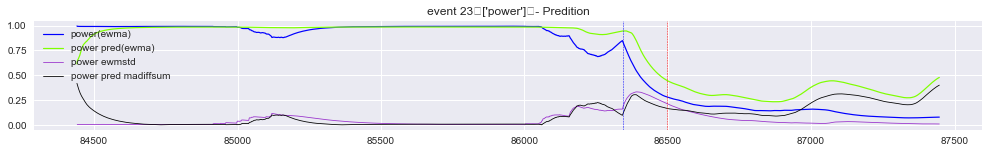

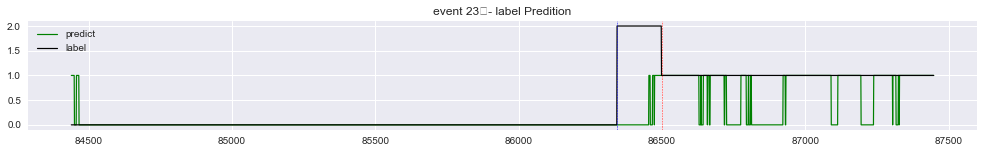

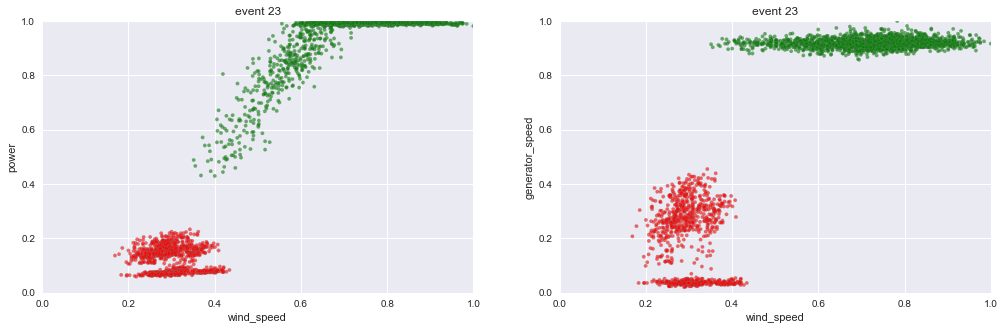

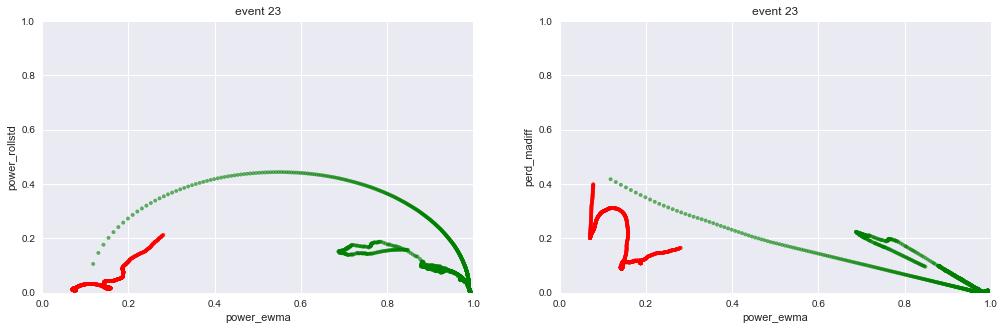

event id: 24


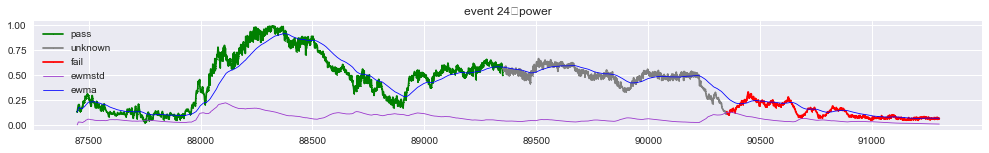

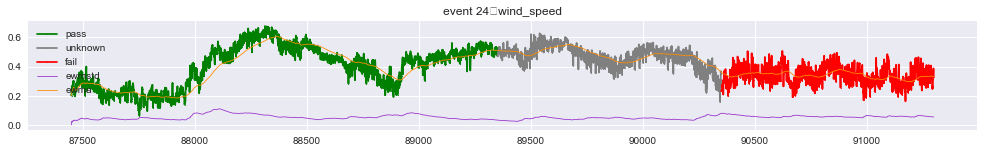

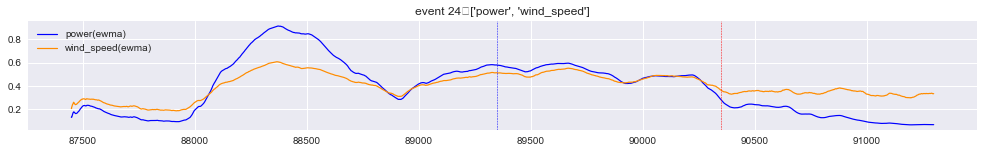

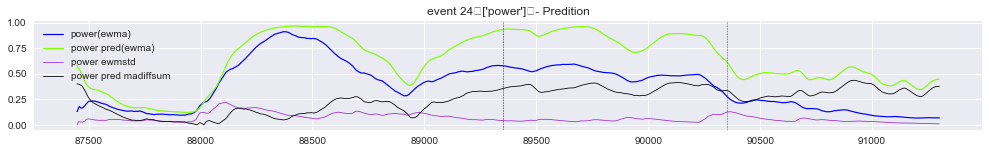

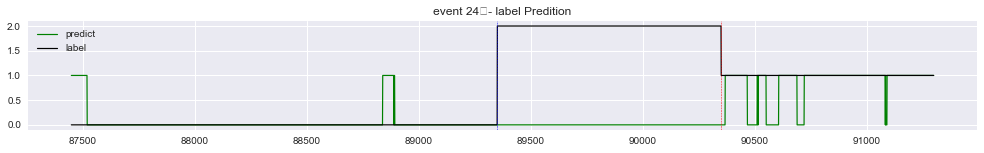

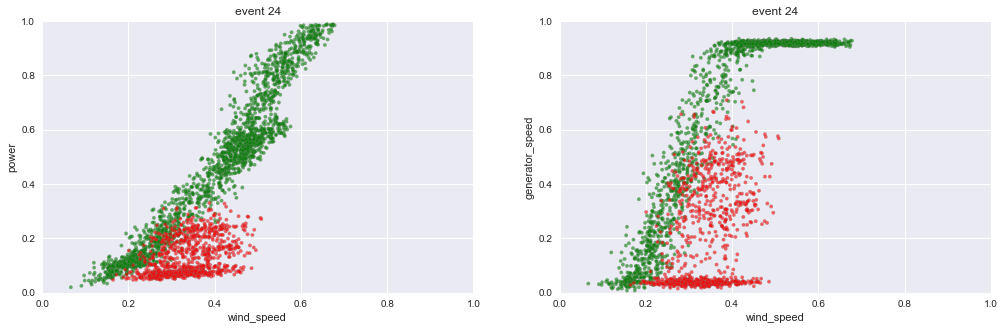

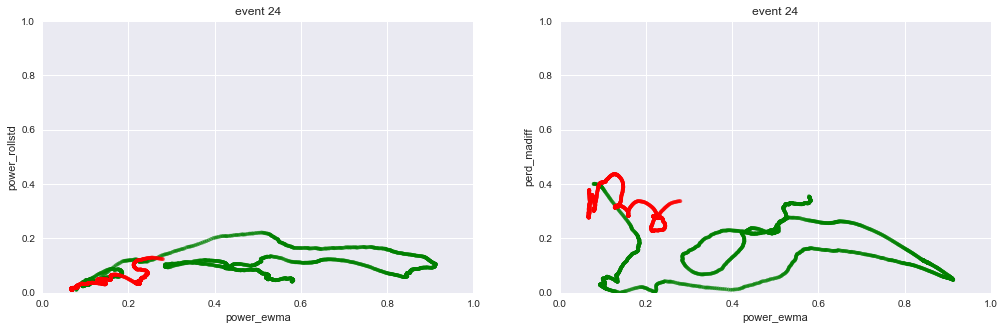

0                    1                    2   \
0       pitch1_moto_tmp       wind_direction      generator_speed   
1            wind_speed       pitch3_ng5_tmp           wind_speed   
2       generator_speed           wind_speed         yaw_position   
3        wind_direction      environment_tmp       wind_direction   
4               int_tmp  wind_direction_mean      environment_tmp   
5        pitch3_ng5_tmp              int_tmp      pitch1_moto_tmp   
6       pitch2_moto_tmp        pitch2_ng5_DC        pitch2_ng5_DC   
7          pitch3_angle      generator_speed       pitch3_ng5_tmp   
8             yaw_speed        pitch1_ng5_DC        pitch1_ng5_DC   
9       environment_tmp            yaw_speed  wind_direction_mean   
10      pitch3_moto_tmp         yaw_position      pitch2_moto_tmp   
11         pitch2_angle        pitch3_ng5_DC      pitch3_moto_tmp   
12        pitch1_ng5_DC       pitch2_ng5_tmp        pitch3_ng5_DC   
13  wind_direction_mean       pitch1_ng5_tmp              int_tmp   
14       pitch1_ng5_tmp                acc_y                acc_y   
15       pitch2_ng5_tmp                acc_x       pitch1_ng5_tmp   
16        pitch2_ng5_DC         pitch1_angle       pitch2_ng5_tmp   
17                acc_y         pitch2_angle            yaw_speed   
18         pitch1_angle         pitch3_angle                acc_x   
19         yaw_position         pitch1_speed         pitch3_speed   
20        pitch3_ng5_DC      pitch3_moto_tmp         pitch2_speed   
21         pitch3_speed         pitch2_speed         pitch1_speed   
22         pitch1_speed      pitch2_moto_tmp         pitch2_angle   
23         pitch2_speed         pitch3_speed         pitch1_angle   
24                acc_x      pitch1_moto_tmp         pitch3_angle   

                     3                    4                    5   \
0       pitch1_moto_tmp           wind_speed       wind_direction   
1            wind_speed      generator_speed      pitch1_moto_tmp   
2       environment_tmp       wind_direction           wind_speed   
3       generator_speed        pitch1_ng5_DC  wind_direction_mean   
4               int_tmp        pitch3_ng5_DC      generator_speed   
5       pitch3_moto_tmp       pitch1_ng5_tmp        pitch2_ng5_DC   
6          pitch1_angle  wind_direction_mean       pitch2_ng5_tmp   
7       pitch2_moto_tmp       pitch3_ng5_tmp       pitch1_ng5_tmp   
8        pitch3_ng5_tmp        pitch2_ng5_DC      pitch2_moto_tmp   
9   wind_direction_mean                acc_x      pitch3_moto_tmp   
10       pitch1_ng5_tmp                acc_y        pitch1_ng5_DC   
11         pitch2_angle              int_tmp        pitch3_ng5_DC   
12       wind_direction            yaw_speed      environment_tmp   
13         yaw_position      environment_tmp                acc_y   
14       pitch2_ng5_tmp       pitch2_ng5_tmp              int_tmp   
15         pitch3_angle         yaw_position       pitch3_ng5_tmp   
16                acc_y      pitch1_moto_tmp                acc_x   
17        pitch3_ng5_DC      pitch3_moto_tmp            yaw_speed   
18        pitch2_ng5_DC         pitch1_angle         pitch1_speed   
19                acc_x      pitch2_moto_tmp         pitch3_angle   
20         pitch1_speed         pitch2_angle         pitch2_angle   
21         pitch3_speed         pitch3_angle         pitch1_angle   
22        pitch1_ng5_DC         pitch1_speed         yaw_position   
23         pitch2_speed         pitch3_speed         pitch3_speed   
24            yaw_speed         pitch2_speed         pitch2_speed   

                     6                    7                    8   \
0       pitch2_moto_tmp      generator_speed      environment_tmp   
1       generator_speed           wind_speed      generator_speed   
2            wind_speed      pitch1_moto_tmp      pitch1_moto_tmp   
3       environment_tmp       pitch1_ng5_tmp           wind_speed   
4       pitch1_moto_tmp              int_tmp       pitch2_ng5_tmp   
5               i

0   \
score                                        0.5   
f1                                           NaN   
prec                                         NaN   
recall                                         0   
info    {'tn': 887, 'fn': 442, 'tp': 0, 'fp': 0}   

                                                1   \
score                                     0.622411   
f1                                        0.568353   
prec                                      0.396992   
recall                                           1   
info    {'tn': 130, 'fn': 0, 'tp': 264, 'fp': 401}   

                                                  2   \
score                                       0.664777   
f1                                          0.513475   
prec                                        0.786957   
recall                                      0.381053   
info    {'tn': 1805, 'fn': 588, 'tp': 362, 'fp': 98}   

                                                    3   \
score                                         0.667284   
f1                                            0.521193   
prec                                          0.764977   
recall                                        0.395238   
info    {'tn': 3948, 'fn': 1270, 'tp': 830, 'fp': 255}   

                                               4   \
score                                    0.621999   
f1                                       0.435897   
prec                                     0.666667   
recall                                    0.32381   
info    {'tn': 196, 'fn': 71, 'tp': 34, 'fp': 17}   

                                                5   \
score                                     0.875432   
f1                                        0.846626   
prec                                      0.916944   
recall                                    0.786325   
info    {'tn': 680, 'fn': 75, 'tp': 276, 'fp': 25}   

                                                    6   \
score                                         0.953469   
f1                                            0.935585   
prec                                          0.902997   
recall                                        0.970613   
info    {'tn': 5426, 'fn': 104, 'tp': 3435, 'fp': 369}   

                                                   7   \
score                                        0.489176   
f1                                           0.290268   
prec                                         0.315985   
recall                                       0.268421   
info    {'tn': 1351, 'fn': 695, 'tp': 255, 'fp': 552}   

                                                   8   \
score                                        0.839444   
f1                                           0.820216   
prec                                         0.976803   
recall                                       0.706897   
info    {'tn': 1284, 'fn': 646, 'tp': 1558, 'fp': 37}   

                                               9   \
score                                    0.649145   
f1                                       0.530612   
prec                                     0.530612   
recall                                   0.530612   
info    {'tn': 228, 'fn': 69, 'tp': 78, 'fp': 69}   

                                                  10  \
score                                       0.912396   
f1                                          0.890949   
prec                                        0.924208   
recall                                          0.86   
info    {'tn': 1836, 'fn': 133, 'tp': 817, 'fp': 67}   

                                                11  \
score                                      0.74047   
f1                                        0.657754   
prec                                       0.49004   
recall                                           1   
info    {'tn': 593, 'fn': 0, 'tp': 615, 'fp': 640}   

                                                  12  \
score 

0         1         2         3         4         5   \
mse_all   0.110604  0.059726  0.075220  0.067585  0.151157  0.107309   
mse_pass  0.045327  0.069908  0.079213  0.089217  0.067493  0.075494   
mse_fail  0.252732  0.075661  0.074529  0.038963  0.122254  0.183727   

                6         7         8         9         10        11  \
mse_all   0.056695  0.046737  0.041355  0.022467  0.054447  0.052800   
mse_pass  0.037619  0.035398  0.006686  0.019059  0.054158  0.052468   
mse_fail  0.090425  0.087962  0.075607  0.029352  0.032790  0.069965   

                12        13        14        15        16        17  \
mse_all   0.065046  0.051774  0.044839  0.015800  0.025153  0.033586   
mse_pass  0.037807  0.023318  0.034983  0.015589  0.030237  0.017306   
mse_fail  0.097103  0.122393  0.073773  0.019400  0.034914  0.043687   

                18        19        20        21        22        23        24  
mse_all   0.115139  0.052070  0.009050  0.031378  0.013011  0.029852  0.082658  
mse_pass  0.054424  0.076868  0.004567  0.019145  0.003401  0.009051  0.040689  
mse_fail  0.236904  0.027931  0.019754  0.055884  0.040379  0.058329  0.113474

In [314]:
print('200 tree','wind_speed_2, wind_speed_3')

fImportance, predScore, powerMse = exploration(data_trained=dat_scaled_M15_Complete, data_pred=dat_scaled_M15, ma=50, tree=200,showpict=True)
predScore_morefeature= predScore.copy()
powerMse_morefeature = powerMse.copy()
fImportance
predScore_morefeature
powerMse_morefeature






** Moving Average的window size對預測準確性的影響 **

In [233]:
print('MA window=25',)
fImportance, predScore, powerMse = exploration(data_trained=dat_scaled_M15_Complete, data_pred=dat_scaled_M15, ma=25, tree=200, showpict=False)
predScore_ma= predScore.copy()
powerMse_ma = powerMse.copy()
predScore_ma
powerMse_ma


MA window=25
get_powerPredictModel Index(['wind_speed', 'wind_direction', 'wind_direction_mean', 'yaw_position',
       'yaw_speed', 'pitch1_angle', 'pitch2_angle', 'pitch3_angle',
       'pitch1_speed', 'pitch2_speed', 'pitch3_speed', 'acc_x', 'acc_y',
       'pitch1_ng5_DC', 'pitch2_ng5_DC', 'pitch3_ng5_DC', 'wind_speed_2',
       'wind_speed_3'],
      dtype='object')


0   \
score                                    0.611991   
f1                                       0.365989   
prec                                            1   
recall                                   0.223982   
info    {'tn': 887, 'fn': 343, 'tp': 99, 'fp': 0}   

                                               1   \
score                                    0.546139   
f1                                       0.522772   
prec                                     0.353887   
recall                                          1   
info    {'tn': 49, 'fn': 0, 'tp': 264, 'fp': 482}   

                                                   2   \
score                                        0.657854   
f1                                           0.552632   
prec                                         0.514519   
recall                                       0.596842   
info    {'tn': 1368, 'fn': 383, 'tp': 567, 'fp': 535}   

                                                    3   \
score                                         0.759192   
f1                                            0.680781   
prec                                          0.805465   
recall                                        0.589524   
info    {'tn': 3904, 'fn': 862, 'tp': 1238, 'fp': 299}   

                                              4   \
score                                   0.903353   
f1                                      0.849785   
prec                                    0.773438   
recall                                  0.942857   
info    {'tn': 184, 'fn': 6, 'tp': 99, 'fp': 29}   

                                                5   \
score                                     0.911099   
f1                                        0.880682   
prec                                      0.878187   
recall                                    0.883191   
info    {'tn': 662, 'fn': 41, 'tp': 310, 'fp': 43}   

                                                   6   \
score                                        0.951757   
f1                                           0.929207   
prec                                         0.876692   
recall                                       0.988415   
info    {'tn': 5303, 'fn': 41, 'tp': 3498, 'fp': 492}   

                                                   7   \
score                                        0.788135   
f1                                           0.707276   
prec                                         0.591231   
recall                                           0.88   
info    {'tn': 1325, 'fn': 114, 'tp': 836, 'fp': 578}   

                                                   8   \
score                                        0.961421   
f1                                           0.965788   
prec                                         0.984449   
recall                                       0.947822   
info    {'tn': 1288, 'fn': 115, 'tp': 2089, 'fp': 33}   

                                                9   \
score                                     0.842988   
f1                                        0.770115   
prec                                      0.666667   
recall                                    0.911565   
info    {'tn': 230, 'fn': 13, 'tp': 134, 'fp': 67}   

                                                  10  \
score                                       0.823628   
f1                                          0.747082   
prec                                        0.633896   
recall                                      0.909474   
info    {'tn': 1404, 'fn': 86, 'tp': 864, 'fp': 499}   

                                                11  \
score                                     0.668289   
f1                                        0.600586   
prec                                       0.42917   
recall                                           1   
info    {'tn': 415, 'fn': 0, 'tp': 615, 'fp': 818}   

                                                   12  \
score 

0         1         2         3         4         5   \
mse_all   0.087125  0.068671  0.065191  0.068962  0.148009  0.086451   
mse_pass  0.027781  0.059493  0.067812  0.082947  0.064108  0.053861   
mse_fail  0.200582  0.100861  0.073160  0.055301  0.165136  0.170209   

                6         7         8         9         10        11  \
mse_all   0.063567  0.059220  0.059744  0.028638  0.062530  0.073005   
mse_pass  0.037660  0.038586  0.008466  0.014264  0.064953  0.064773   
mse_fail  0.109990  0.119723  0.107266  0.057679  0.048424  0.112076   

                12        13        14        15        16        17  \
mse_all   0.070972  0.055269  0.046507  0.025767  0.038134  0.048334   
mse_pass  0.039231  0.029860  0.036043  0.023553  0.040780  0.017539   
mse_fail  0.107229  0.125476  0.079807  0.034111  0.051641  0.061929   

                18        19        20        21        22        23        24  
mse_all   0.111205  0.047436  0.017534  0.045040  0.020563  0.032254  0.091486  
mse_pass  0.050016  0.052053  0.008950  0.027282  0.005134  0.004663  0.043210  
mse_fail  0.233921  0.044835  0.037253  0.080617  0.061129  0.086616  0.164341

** TODO: **  
Power Prediciton:
1. 加入Power類別(stop, operation, saturation)
2. 加入風速的次方

Label Prediciton
1. 加入generator_speed的預測值 & generator預測值的變化
    - rolling_mean
    - ewmstd
    - rolling_sum of (generator_speed_pred - generator_speed)

Data Exploration:
1. 增加power vs windspeed的spearman相關係數(each event, seperate pass/fail/unkonwn) 
2. survey generator_speed和風機效率的關聯

** Observation & Modification **

預測理論Power時可能會有的問題：
- generator speed和power變化正相關, 如果feature裡面有 generator speed, regressor會直接用generator預測power
- 風機開始結冰時, Power會開始下降, 假設結冰時各種溫度也隨之下降, 如果feature裡面有溫度, regressor會用溫度預測power